# Assignment 4: Unsupervised Learning—Clustering and Recommendations
## Group 105
- Natasa Bolic (300241734)
- Brent Palmer (300193610)
## Imports

In [105]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import Levenshtein
import math
import re
from scipy.spatial import distance
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
import torch
from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.interactions import Interactions

In [106]:
# Set-up to run matrix factorization in Study 4 with GPU
gpu_status = True if torch.cuda.is_available() else False
print(gpu_status)

False


## Introduction

## Dataset Description

**Url:** https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset <br>
**Name:** The Movies Dataset <br>
**Author:** The dataset was uploaded by Rounak Banik. The data was collected from the TMDB Open API and the Official GroupLens website. <br>
**Purpose:** The original purpose of the dataset was to learn about the history of cinema through EDA and to build various types of recommender systems for movies. Some suggested uses for the dataset are building models to predict movie revenue or success, and building content based and collaborative filtering based recommendation systems. <br>
**Shape:** The data we are using is separated into two files.
- `movies_metadata.csv`
    - There are 45466 rows and 24 columns. (45466, 24)
- `ratings_small.csv`
    - There are 100004 rows and 4 columns. (100004, 4)

**Features:**
- `movies_metadata.csv`
    - `adult` (categorical): Indicates (True/False) if the movie is rated as "Adults Only", meaning that the content is not suitable for minors.
    - `belongs_to_collection` (categorical): The movie series/collection that the movie belongs to, stored as a string representation of a dictionary that describes the series with keys 'id', 'name', 'poster_path' and 'backdrop_path'.
    - `budget` (numerical): The budget of the movie (in USD).
    - `genres` (categorical): The genres of the movie, stored as a string representation of a list where each item is a dictionary representing a genre with keys 'id' and 'name'.
    - `homepage` (categorical): The link to the official homepage of the movie.
    - `id` (categorical): The movie's ID.
    - `imdb_id` (categorical): The IMDB ID for the movie.
    - `original_language` (categorical): The original language of the movie, abbreviated to the two-letter format (i.e. the ISO 639-1 code).
    - `original_title` (categorical): The title of the movie in its original language.
    - `overview` (categorical): A short description of the movie.
    - `popularity` (numerical): The score assigned by TMBD to quantify the movie's popularity.
    - `poster_path` (categorical): The path segment of the URL to the poster image of the movie.
    - `production_companies` (categorical): The production companies that were involved with the production of the movie, stored as a string representation of a list where each item is a dictionary representing a company with keys 'id' and 'name'.
    - `production_countries` (categorical): The countries where the movie was made, stored as a string representation of a list where each item is a dictionary representing a country with keys 'iso_3166_1' (2-letter format) and 'name'.
    - `release_date` (categorical): The release date of the movie in the format YYYY-MM-DD.
    - `revenue` (numerical): The total revenue generated by the movie (in USD). 
    - `runtime` (numerical): The length of the movie (in minutes).
    - `spoken_languages` (categorical): The languages spoken in the movie, stored as a string representation of a list where each item is a dictionary representing a language with keys 'iso_639_1' (2-letter format) and 'name'.
    - `status` (categorical): The status of the movie, which is either released, rumored, planned, post production, or in production.
    - `tagline` (categorical): The movie's tagline.
    - `title` (categorical): The title of the movie in English.
    - `video` (categorical): Indicates (True/False) if the movie has an official video associated with it in the TMBD API.
    - `vote_average` (numerical): The average rating given to the movie by users.
    - `vote_count` (numerical): The number of users that rated the movie.
- `ratings_small.csv`
    - `userId` (categorical): The ID of the user that provided the rating.
    - `movieId` (categorical): The ID of the movie that was rated.
    - `rating` (categorical): The rating given to the movie by the user.
    - `timestamp` (categorical): The timestamp at which the rating was provided.

We chose this dataset because we love watching and commenting on movies. In fact, one of our members has watched 200 movies in the last 3 years, and has statistically studied the distribution of movies they've watched in the past. So, we are interested in this domain and we have some experience with it as well. Moreover, we noticed that there is a good mix of numerical and categorical features in the dataset, which is useful for varied analysis. Finally, the dataset included both metadata about the movies and ratings for the movies by users, which allowed us to create multiple recommendation systems.

We specifically chose to use `ratings_small.csv` as opposed to `ratings.csv` because we found the size more manageable when creating the utility matrix and performing matrix factorization.

## Loading Data and Basic Exploration

### Loading Movies Metadata Dataset

In [107]:
# Read in the movies metadata dataset from a public repository
url = "https://raw.githubusercontent.com/BrentMRPalmer/CSI4142-A4/refs/heads/main/movies_metadata.csv"
metadata_df = pd.read_csv(url, low_memory=False)
metadata_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [108]:
metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [109]:
metadata_df.shape

(45466, 24)

### Loading Ratings Small Dataset

In [110]:
# Read in the ratings small dataset from a public repository
url = "https://raw.githubusercontent.com/BrentMRPalmer/CSI4142-A4/refs/heads/main/ratings_small.csv"
ratings_df = pd.read_csv(url, low_memory=False)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [111]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [112]:
ratings_df.shape

(100004, 4)

## Data Preparation

To prepare the data, we use our validation techniques from Assignment 2 to clean the data and our EDA techniques from Assignment 1 to visualize the data.

There are two datasets to prepare, the first holding the metadata in `metadata_df`, and the second representing the user ratings in `ratings_df`. We perform the preparation on one dataset at a time.

### Cleaning and EDA of Metadata

We begin by cleaning and performing EDA on the metadata dataset.

#### Cleaning the Data

##### Validity Check 1: Exact Duplicates

We will first check for exact duplicates in the dataset, verifying that there are no rows that are identical over all columns.

**References:** <br>
Duplicated: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html <br>
Drop duplicates: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html

In [113]:
# Exact duplicates check

# Apply the .duplicated method to the DataFrame to create a Series, with exact duplicates set to True
# keep=False will mark all duplicates as True (including the first and last occurrences)
duplicates = metadata_df.duplicated(keep=False)

# Print the number of rows that are exact duplicates
print(f"Number of duplicate rows: {duplicates.sum()}\n")

Number of duplicate rows: 33



Since there are 33 duplicate rows, let us further investigate the actual rows to determine how to handle them.

In [114]:
# Display the first 3 rows that are exact duplicates
print("Examples of three duplicate rows:")
metadata_df.loc[duplicates].head(3)

Examples of three duplicate rows:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
676,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,105045,tt0111613,de,Das Versprechen,"East-Berlin, 1961, shortly after the erection ...",...,1995-02-16,0.0,115.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,"A love, a hope, a wall.",The Promise,False,5.0,1.0
1465,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,105045,tt0111613,de,Das Versprechen,"East-Berlin, 1961, shortly after the erection ...",...,1995-02-16,0.0,115.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,"A love, a hope, a wall.",The Promise,False,5.0,1.0
7345,False,NaN,0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,5511,tt0062229,fr,Le Samouraï,Hitman Jef Costello is a perfectionist who alw...,...,1967-10-25,39481.0,105.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,There is no solitude greater than that of the ...,Le Samouraï,False,7.9,187.0


As expected, the rows are exact duplicates. The movie `Das Versprechen` appears twice in the results above. We can safely remove the duplicates. We will store the results in a new DataFrame called `cleaned_metadata_df`. All subsequent cleaning will be done to the new DataFrame.

In [115]:
# Create a copy of the metadata DataFrame
cleaned_metadata_df = metadata_df.copy()

# Drop duplicates (retains first instance of a duplicated row)
cleaned_metadata_df = cleaned_metadata_df.drop_duplicates()

# verify no duplicates remain
duplicates = cleaned_metadata_df.duplicated(keep=False)

# Print the number of rows that are exact duplicates
print(f"Number of duplicate rows: {duplicates.sum()}\n")

Number of duplicate rows: 0



Since there are no remaining duplicate rows, the DataFrame has been successfully cleaned.

##### Validity Check 2: Data Type Check

Next, we will use the data type check to validate that the data stored is the correct data type. We will check the numerical features, which includes:
- `budget`: float
- `popularity`: float
- `revenue`: float
- `runtime`: float
- `vote_average`: float
- `vote_count`: float

We will first use our `method 1` from `Assignment 2`, which optimistically checks if the data is already stored as the correct data type. We specify a dictionary, where the keys are the features, and the values are the desired data types. We iterate over each feature in the dictionary, applying the data type check to each.

In [116]:
# Data type check

# Evalutes a single value's data type against the desired data type
def type_filter_method1(value, test_datatype):
    if pd.isna(value):
        return False
    return isinstance(value, test_datatype)

# Create a dictionary that maps each attribute to its correct datatype
data_type_dict = {
    "budget": float,
    "popularity": float,
    "revenue": float,
    "runtime": float,
    "vote_average": float,
    "vote_count": float
}

# Apply the function to every feature, setting rows whose value is not stored as the correct datatype to True
for feature in data_type_dict.keys():
    invalid_datatype = cleaned_metadata_df[feature].apply(
        lambda attribute: not type_filter_method1(attribute, data_type_dict[feature])
    )
    # Print the number of rows with a value that is not stored as the correct datatype for the designated attribute
    print(f"Number of rows where the {feature} value is not stored as the correct datatype ({data_type_dict[feature]}): {invalid_datatype.sum()}")

Number of rows where the budget value is not stored as the correct datatype (<class 'float'>): 45449
Number of rows where the popularity value is not stored as the correct datatype (<class 'float'>): 45449
Number of rows where the revenue value is not stored as the correct datatype (<class 'float'>): 6
Number of rows where the runtime value is not stored as the correct datatype (<class 'float'>): 263
Number of rows where the vote_average value is not stored as the correct datatype (<class 'float'>): 6
Number of rows where the vote_count value is not stored as the correct datatype (<class 'float'>): 6


Clearly, the optimistic approach of checking if the data is already stored as the correct datatype found that none of the features stored the data as the correct datatype. Many features are mostly correct, but none are perfect. We will now use our less optimistic `method 2` from `Assignment 2`, which checks if the data can be cast to the desired datatype. In some cases, the data could be perfectly fine, but it is just stored as a string instead of the desired type. Thus, `method 2` will uncover if the value of the underlying data is of the correct type.

In [117]:
# Evalutes a single value's data type against the desired data type
def type_filter_method2(value, test_datatype):
    if pd.isna(value):
        return False
    if test_datatype == int:
        try:
            value = float(value)
            return value % 1 == 0
        except Exception as e:
            return False
    else:
        try:
            value = test_datatype(value)
            return True
        except Exception as e:
            return False

# Apply the function to every feature, setting rows whose value is not stored as the correct datatype to True
for feature in data_type_dict.keys():
    invalid_datatype = cleaned_metadata_df[feature].apply(
        lambda attribute: not type_filter_method2(attribute, data_type_dict[feature])
    )
    # Print the number of rows with a value that is not stored as the correct datatype for the designated attribute
    print(f"Number of rows where the {feature} value is not stored as the correct datatype ({data_type_dict[feature]}): {invalid_datatype.sum()}")

Number of rows where the budget value is not stored as the correct datatype (<class 'float'>): 3
Number of rows where the popularity value is not stored as the correct datatype (<class 'float'>): 6
Number of rows where the revenue value is not stored as the correct datatype (<class 'float'>): 6
Number of rows where the runtime value is not stored as the correct datatype (<class 'float'>): 263
Number of rows where the vote_average value is not stored as the correct datatype (<class 'float'>): 6
Number of rows where the vote_count value is not stored as the correct datatype (<class 'float'>): 6


We find that for all features, the majority of values can be cast to the correct datatype. However, in all instances some values cannot be cast. We will now investigate each feature to determine the root cause. Having found the cause, we will find an appropriate method to handle the invalid cases. We first assess the `budget` feature, storing and printing examples of invalid rows to determine the issue.

In [118]:
# Apply the function to the budget feature, setting rows with values with an invalid data type to True
invalid_datatype = cleaned_metadata_df["budget"].apply(
    lambda attribute: not type_filter_method2(attribute, data_type_dict["budget"])
)

# Save the invalid rows
invalid_datatype_df = cleaned_metadata_df.loc[invalid_datatype]

# Print the number of rows where the test attribute value contains an incorrect datatype
print(f"Number of rows where the budget value's data type is not float: {invalid_datatype.sum()}\n")

# Display all rows where the test attribute value contains an incorrect datatype
print(f"All rows where the budget value's data type is not float:")
invalid_datatype_df.head(3)

Number of rows where the budget value's data type is not float: 3

All rows where the budget value's data type is not float:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


These values are a complete type mismatch—it is clear that these are misplaced `.jpg` relative file paths. We choose to replace these values with `0`, since the dataset uses `0` to represent missing data in this category. In the process, we also cast all the values to numerics, since they are currently stored as strings. To convert the 3 incorrect cases to `0`, we simply use `errors="coerce"` to replace the values that cannot be cast with `NaN`, and `fillna(0)` to convert the new `NaN` values to `0`. We will verify that the cleaning worked for each feature after having first cleaned all features.

**References:** <br>
To Numeric: https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html <br>
Fillna: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html

In [119]:
# Cast the values to numeric, and set errors to 0
cleaned_metadata_df["budget"] = pd.to_numeric(cleaned_metadata_df["budget"], errors="coerce").fillna(0)

Having cleaned `budget`, we move on to evaluating `popularity`. We use the same techniques used to assess `budget`.

In [120]:
# Apply the function to the popularity feature, setting rows with values with an invalid data type to True
invalid_datatype = cleaned_metadata_df["popularity"].apply(
    lambda attribute: not type_filter_method2(attribute, data_type_dict["popularity"])
)

# Save the invalid rows
invalid_datatype_df = cleaned_metadata_df.loc[invalid_datatype]

# Print the number of rows where the test attribute value contains an incorrect datatype
print(f"Number of rows where the popularity value's data type is not float: {invalid_datatype.sum()}\n")

# Display the invalid popularity values
print("The invalid popularity values are: ")
print(f"{invalid_datatype_df['popularity']}\n")

# Display the rows where the test attribute value contains an incorrect datatype
print(f"All rows where the popularity value's data type is not float:")
invalid_datatype_df.head(6)

Number of rows where the popularity value's data type is not float: 6

The invalid popularity values are: 
19729                      NaN
19730                      NaN
29502                      NaN
29503                      NaN
35586                      NaN
35587    Beware Of Frost Bites
Name: popularity, dtype: object

All rows where the popularity value's data type is not float:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19729,False,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,82663,tt0113002,en,Midnight Man,British soldiers force a recently captured IRA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19730,- Written by Ørnås,0.065736,0.0,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29502,False,"{'id': 122661, 'name': 'Mardock Scramble Colle...",0.0,"[{'id': 16, 'name': 'Animation'}, {'id': 878, ...",http://m-scramble.jp/exhaust/,122662,tt2423504,ja,マルドゥック・スクランブル 排気,Third film of the Mardock Scramble series.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,0.0,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35586,False,NaN,0.0,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 28,...",NaN,249260,tt2622826,en,Avalanche Sharks,A group of skiers are terrorized during spring...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,0.0,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In five out of six cases, the `popularity` value is simply missing, and in the sixth case, the popularity value is clearly incorrect (`Beware of Frost Bites`). Observing the values of the other features, we note that this data is completely unusable. Most useful values are missing (`revenue`, `runtime`, `tagline`, `title`, etc.), and in many cases, those that are not missing are incorrect. Often, the feature's values are stored in the wrong feature; for example, the language is stored in the `original_title` in three cases. We reason that since the data for these rows is both inaccurate and incomplete, they provide no value to our study and should be removed using the listwise removal approach. Note that it is also only six rows, so this does not delete a significant amount of data. We also must cast the remaining values to numeric.

In [121]:
# Remove the invalid rows
cleaned_metadata_df = cleaned_metadata_df[~invalid_datatype]

# Cast the values to numeric
cleaned_metadata_df["popularity"] = pd.to_numeric(cleaned_metadata_df["popularity"], errors="coerce")

Having cleaned `popularity`, we move on to evaluating `revenue`. We use the same techniques used to assess `popularity`.

In [122]:
# Apply the function to the revenue feature, setting rows with values with an invalid data type to True
invalid_datatype = cleaned_metadata_df["revenue"].apply(
    lambda attribute: not type_filter_method2(attribute, data_type_dict["revenue"])
)

# Save the invalid rows
invalid_datatype_df = cleaned_metadata_df.loc[invalid_datatype]

# Print the number of rows where the test attribute value contains an incorrect datatype
print(f"Number of rows where the revenue value's data type is not float: {invalid_datatype.sum()}\n")

# Display the rows where the test attribute value contains an incorrect datatype
print(f"All rows where the revenue value's data type is not float:")
invalid_datatype_df.head(6)

Number of rows where the revenue value's data type is not float: 0

All rows where the revenue value's data type is not float:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count


We find that there are no values that cannot be cast to a float. This makes sense, as we observed that there were only six invalid rows for the `revenue` feature, and we removed six rows that had `NaN` values for `revenue` in the previous step. Thus, the invalid rows have already been removed. No cleaning is required for this feature, as `method 1` indicated the values are already floats. We move on to evaluating `runtime`. We use the same techniques used to assess `revenue`.

In [123]:
# Apply the function to the runtime feature, setting rows with values with an invalid data type to True
invalid_datatype = cleaned_metadata_df["runtime"].apply(
    lambda attribute: not type_filter_method2(attribute, data_type_dict["runtime"])
)

# Save the invalid rows
invalid_datatype_df = cleaned_metadata_df.loc[invalid_datatype]

# Print the number of rows where the test attribute value contains an incorrect datatype
print(f"Number of rows where the runtime value's data type is not float: {invalid_datatype.sum()}\n")

# Display the number of NaN runtime values
print(f"The number of NaN runtime values is: {invalid_datatype_df['runtime'].isna().sum()}\n")

# Display the rows where the test attribute value contains an incorrect datatype
print(f"Three rows where the runtime value's data type is not float:")
invalid_datatype_df.head(3)

Number of rows where the runtime value's data type is not float: 257

The number of NaN runtime values is: 257

Three rows where the runtime value's data type is not float:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
634,False,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,287305,tt0117312,de,Peanuts – Die Bank zahlt alles,NaN,...,1996-03-21,0.0,NaN,[],Released,NaN,Peanuts – Die Bank zahlt alles,False,4.0,1.0
635,False,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,339428,tt0116485,de,Happy Weekend,NaN,...,1996-03-14,65335.0,NaN,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,NaN,Happy Weekend,False,0.0,0.0
644,False,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,278978,tt0118026,de,Und keiner weint mir nach,NaN,...,1996-02-29,0.0,NaN,"[{'iso_639_1': 'de', 'name': 'Deutsch'}]",Released,NaN,Und keiner weint mir nach,False,0.0,0.0


We find that there are `257` values that cannot be cast to float. We also note that they are all `NaN`, corresponding to missing values for the `runtime`. We observe that the rows contain otherwise valid data, so we do not perform listwise removal. Instead, we choose to impute the median value of the `runtime`. We believe median imputation is appropriate, as the `runtime` values are heavily clustered around the median, as visualized below.

**References:** <br>
Dropping a specific row: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html <br>
Freedman-Diaconis: https://stats.stackexchange.com/questions/798/calculating-optimal-number-of-bins-in-a-histogram <br>
Gridlines: https://www.w3schools.com/python/matplotlib_grid.asp <br>
Histplot: https://seaborn.pydata.org/generated/seaborn.histplot.html <br>
Boxplot: https://seaborn.pydata.org/generated/seaborn.boxplot.html <br>
Median line: https://stackoverflow.com/questions/16180946/drawing-average-line-in-histogram <br>
Xlim: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xlim.html

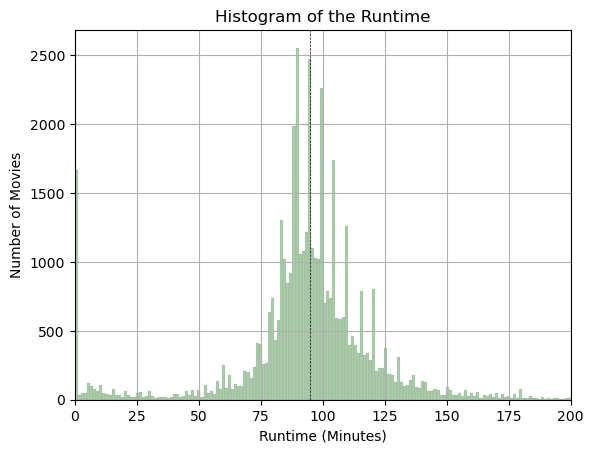

In [124]:
# Visualize the runtime distribution before imputation

no_na_runtime_df = cleaned_metadata_df.dropna(subset=['runtime'])

# Use Freedman-Diaconis rule to determine number of bins
x_axis = "runtime"
iqr = np.percentile(no_na_runtime_df[x_axis], 75) - np.percentile(no_na_runtime_df[x_axis], 25)
bin_width = 2 * iqr / (len(no_na_runtime_df[x_axis]) ** (1/3))
num_bins = int((no_na_runtime_df[x_axis].max() - no_na_runtime_df[x_axis].min()) / bin_width)

# Create the histogram of runtime
sns.histplot(data=no_na_runtime_df, x=x_axis, bins=num_bins, color="darkseagreen")

# Label the histogram
plt.xlabel(x_axis.title() + " (Minutes)")
plt.ylabel('Number of Movies')
plt.title('Histogram of the ' + x_axis.title())
plt.grid()
plt.axvline(no_na_runtime_df[x_axis].median(), color='k', linestyle='dashed', linewidth=0.5)
plt.xlim(0, 200)

# Display plot
plt.show()

In [125]:
# Save the median of the non-missing runtime values
runtime_median = cleaned_metadata_df.loc[cleaned_metadata_df['runtime'].notna(), 'runtime'].median()

# Replace the missing values with the median
cleaned_metadata_df.loc[invalid_datatype, "runtime"] = runtime_median

Having imputed the median `runtime` value to the missing values, we move on to evaluating `vote_average`. We use the same techniques used to assess `runtime`.

In [126]:
# Apply the function to the vote_average feature, setting rows with values with an invalid data type to True
invalid_datatype = cleaned_metadata_df["vote_average"].apply(
    lambda attribute: not type_filter_method2(attribute, data_type_dict["vote_average"])
)

# Save the invalid rows
invalid_datatype_df = cleaned_metadata_df.loc[invalid_datatype]

# Print the number of rows where the test attribute value contains an incorrect datatype
print(f"Number of rows where the vote_average value's data type is not float: {invalid_datatype.sum()}\n")

# Display the rows where the test attribute value contains an incorrect datatype
print(f"All rows where the vote_average value's data type is not float:")
invalid_datatype_df.head()

Number of rows where the vote_average value's data type is not float: 0

All rows where the vote_average value's data type is not float:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count


We find that there are no values that cannot be cast to a float. This makes sense, as we observed that there were only six invalid rows for the `vote_average` feature, and we removed six rows that had `NaN` values for `revenue` in the previous step. Thus, the invalid rows have already been removed. No cleaning is required for this feature, as `method 1` indicated the values are already floats. We move on to evaluating `vote_count`. We use the same techniques used to assess `vote_average`.

In [127]:
# Apply the function to the vote_count feature, setting rows with values with an invalid data type to True
invalid_datatype = cleaned_metadata_df["vote_count"].apply(
    lambda attribute: not type_filter_method2(attribute, data_type_dict["vote_count"])
)

# Save the invalid rows
invalid_datatype_df = cleaned_metadata_df.loc[invalid_datatype]

# Print the number of rows where the test attribute value contains an incorrect datatype
print(f"Number of rows where the vote_count value's data type is not float: {invalid_datatype.sum()}\n")

# Display the rows where the test attribute value contains an incorrect datatype
print(f"All rows where the vote_count value's data type is not float:")
invalid_datatype_df.head()

Number of rows where the vote_count value's data type is not float: 0

All rows where the vote_count value's data type is not float:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count


We find that there are no values that cannot be cast to a float. This makes sense, as we observed that there were only six invalid rows for the `vote_count` feature, and we removed six rows that had `NaN` values for `revenue` in the previous step. Thus, the invalid rows have already been removed. No cleaning is required for this feature, as `method 1` indicated the values are already floats. We move on to verifying that the cleaning steps worked, be rerunning `method 1` on all features.

In [128]:
# Apply the function to every feature, setting rows whose value is not stored as the correct datatype to True
for feature in data_type_dict.keys():
    invalid_datatype = cleaned_metadata_df[feature].apply(
        lambda attribute: not type_filter_method1(attribute, data_type_dict[feature])
    )
    # Print the number of rows with a value that is not stored as the correct datatype for the designated attribute
    print(f"Number of rows where the {feature} value is not stored as the correct datatype ({data_type_dict[feature]}): {invalid_datatype.sum()}")

Number of rows where the budget value is not stored as the correct datatype (<class 'float'>): 0
Number of rows where the popularity value is not stored as the correct datatype (<class 'float'>): 0
Number of rows where the revenue value is not stored as the correct datatype (<class 'float'>): 0
Number of rows where the runtime value is not stored as the correct datatype (<class 'float'>): 0
Number of rows where the vote_average value is not stored as the correct datatype (<class 'float'>): 0
Number of rows where the vote_count value is not stored as the correct datatype (<class 'float'>): 0


As no rows contain values that are not stored as the correct datatype, we have successfully cleaned our data.

##### Validity Check 3: Format Errors

In this check, we would typically run a regex against a specific feature to determine whether or not it is in the correct format. However, in this case, we do not need to run the format check for two of our three target features, as we know certain features are not in the desired format directly from the dataset description and visual inspection. Thus, we will skip ahead to formatting the two features that we are using that are not in the desired format. Specifically, the two features we will be immediately cleaning include:
- `genres`: The genres of the movie, stored as a string representation of a list where each item is a dictionary representing a genre with keys `id` and `name`.
    - For `Study 1`, we want the `genres` stored directly as a list of the names as the genres such that we can compute Jaccard similarity on them. The genre `id` provides no value and can be safely removed.
    - Original format example: `[{'id': 16, 'name': 'Animation'}, {'id': 10749, 'name': 'Romance'}]`
    - Desired format example: `["Animation", "Romance"]` 
- `production_companies`: The production companies that were involved with the production of the movie, stored as a string representation of a list where each item is a dictionary representing a company with keys `id` and `name`.
    - For `Study 1`, we want the `production_companies` stored directly as a list of the names as the production companies such that we can compute the Sorensen-Dice Index on them. The production company `id` provides no value and can be safely removed.
    - Original format example: `[{'name': 'Pixar Animation Studios', 'id': 3}, {'name': 'Warner Bros.', 'id': 6194}]`
    - Desired format example: `['Pixar Animation Studios', 'Warner Bros.']`

We follow our cleaning of `genres` and `production_companies` with a more traditional approach to the validity check, first checking the validity of the `release_date` feature using our validity check from `Assignment 2`, then cleaning the data if necessary. Specifically, we validate that the `release_date` is in the format `YYYY-MM-DD`.

We begin with cleaning the `genres` format. We will first demonstrate what the original `genres` values look like.

**References:** <br>
Literal eval: https://docs.python.org/3/library/ast.html#ast.literal_eval <br>
Capitalize: https://www.w3schools.com/python/ref_string_capitalize.asp

In [129]:
# Provide examples of original genres values
cleaned_metadata_df["genres"]

0        [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1        [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2        [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
3        [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
4                           [{'id': 35, 'name': 'Comedy'}]
                               ...                        
45461    [{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...
45462                        [{'id': 18, 'name': 'Drama'}]
45463    [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...
45464                                                   []
45465                                                   []
Name: genres, Length: 45443, dtype: object

As described above, the `genres` are stored as a string which holds a list of dictionaries, where each dictionary represents a genre with keys `id` and `name`. We wish to extract the `name` from each genre. To do so, we create a function that takes the string and stores it as a list using `ast.literal_eval()`. Then, we can iterate over each genre and extract the name. We normalize the names using `lower()` and `capitalize()` to ensure consistent casing. We apply this function to each movie in the DataFrame, overwriting the old `genres` with the new list of extracted names.

In [130]:
# Extract the genres for a specific movie
def extract_genres(genres):
    # Convert from string to list
    genres = ast.literal_eval(genres)

    # Iterate over each genre, extracting the name
    for i in range(len(genres)):
        genres[i] = genres[i]["name"].lower().capitalize()
    return genres

# Apply the function to the genres attribute, updating the genres to the processed list
cleaned_metadata_df["genres"] = cleaned_metadata_df["genres"].apply(extract_genres)

# Check the cleaned results
print("Examples of the cleaned genres feature: ")
cleaned_metadata_df["genres"]

Examples of the cleaned genres feature: 


0         [Animation, Comedy, Family]
1        [Adventure, Fantasy, Family]
2                   [Romance, Comedy]
3            [Comedy, Drama, Romance]
4                            [Comedy]
                     ...             
45461                 [Drama, Family]
45462                         [Drama]
45463       [Action, Drama, Thriller]
45464                              []
45465                              []
Name: genres, Length: 45443, dtype: object

As desired, the `genres` names have been successfully extracted and stored in their correct format. We move on to cleaning the `production_companies` feature in a similar way. We will first demonstrate what the original `production_companies` values look like.

In [131]:
# Provide examples of original production companies values
cleaned_metadata_df["production_companies"]

0           [{'name': 'Pixar Animation Studios', 'id': 3}]
1        [{'name': 'TriStar Pictures', 'id': 559}, {'na...
2        [{'name': 'Warner Bros.', 'id': 6194}, {'name'...
3        [{'name': 'Twentieth Century Fox Film Corporat...
4        [{'name': 'Sandollar Productions', 'id': 5842}...
                               ...                        
45461                                                   []
45462               [{'name': 'Sine Olivia', 'id': 19653}]
45463    [{'name': 'American World Pictures', 'id': 6165}]
45464                 [{'name': 'Yermoliev', 'id': 88753}]
45465                                                   []
Name: production_companies, Length: 45443, dtype: object

As described above, the production companies are stored as a string which holds a list of dictionaries, where each dictionary represents a production company with keys `id` and `name`. We wish to extract the `name` from each production company. To do so, we iterate over each movie, sending their `production_companies` values to our `extract_companies` function. Our function returns `[]` if the value is missing. Then, we extract the list from the string using `ast.literal_eval()`. Finally, we can iterate over each production company and extract the name. We normalize the names using `lower()` and `capitalize()` to ensure consistent casing. We apply this function to each movie in the DataFrame, overwriting the old `production_companies` with the new list of extracted names.

In [132]:
# Extract the production companies for a specific movie
def extract_companies(companies):
    # Handle missing companies
    if companies == [] or pd.isna(companies): 
        return []
        
    # Convert from string to list
    companies = ast.literal_eval(companies)

    # Iterate over each company, extracting the name
    for i in range(len(companies)):
        companies[i] = companies[i]["name"].lower().capitalize()
    return companies

# Apply the function to the production companies attribute, updating the production companies to the processed list 
cleaned_metadata_df["production_companies"] = cleaned_metadata_df["production_companies"].apply(extract_companies)

# Check the cleaned results
print("Examples of the cleaned production companies feature: ")
cleaned_metadata_df["production_companies"]

Examples of the cleaned production companies feature: 


0                                [Pixar animation studios]
1        [Tristar pictures, Teitler film, Interscope co...
2                           [Warner bros., Lancaster gate]
3                 [Twentieth century fox film corporation]
4             [Sandollar productions, Touchstone pictures]
                               ...                        
45461                                                   []
45462                                        [Sine olivia]
45463                            [American world pictures]
45464                                          [Yermoliev]
45465                                                   []
Name: production_companies, Length: 45443, dtype: object

As desired, the `production_companies` names have been successfully extracted and stored in their correct format. We now move on to checking the validity of `release_date` using our validity checker from `Assignment 2`. We verify the `release_date` is in the format `YYYY-MM-DD`.

In [133]:
# Format check

# Test attribute
test_attribute = "release_date"

# We will fix the regex for the release_date format (YYYY-MM-DD)
format_regex = r"^\d{4}-\d{2}-\d{2}$"

# Evaluates a single value against a given regex format
def format_filter(value, format_regex):
    return False if not isinstance(value, str) else bool(re.findall(format_regex, value))

# Apply the function to the test attribute, setting invalid formats to True
invalid_format = cleaned_metadata_df[test_attribute].apply(
    lambda attribute: not format_filter(attribute, format_regex)
)

# Save the invalid rows
invalid_format_df = cleaned_metadata_df.loc[invalid_format]

# Print the number of rows with invalid formatting on the chosen test attribute
print(f"Number of rows where the {test_attribute} value has an invalid format: {invalid_format.sum()}\n")

# Display the first 3 rows with invalid formatting on the chosen test attribute
print(f"Examples of three rows where the {test_attribute} value has an invalid format:")
invalid_format_df.head(3)

Number of rows where the release_date value has an invalid format: 84

Examples of three rows where the release_date value has an invalid format:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
711,False,NaN,0.0,[],NaN,365371,tt0114894,en,War Stories Our Mother Never Told Us,Seven New Zealand women speak about their live...,...,NaN,0.0,95.0,[],Released,NaN,War Stories Our Mother Never Told Us,False,0.0,0.0
734,False,NaN,0.0,[],NaN,215107,tt0105737,en,Vermont Is for Lovers,Vermont is for Lovers is an independently prod...,...,NaN,0.0,88.0,[],Released,NaN,Vermont Is for Lovers,False,0.0,0.0
3460,False,NaN,0.0,[Drama],NaN,94214,tt0210130,en,"Jails, Hospitals & Hip-Hop","Jails, Hospitals &amp; Hip-Hop is a cinematic ...",...,NaN,10.0,90.0,[],NaN,three worlds / two million voices / one genera...,"Jails, Hospitals & Hip-Hop",False,0.0,0.0


We note that there are 84 rows with an invalid `release_date` format. However, we also note that the provided examples are all simply missing a `release_date` value. We verify that all 84 incorrectly formatted `release_date` values are in fact just missing values.

In [134]:
cleaned_metadata_df["release_date"].isna().sum()

84

As expected, the 84 values with an incorrect format are simply just missing values. All of the present values are in the correct format. We choose to leave the missing values as `NaN` is adequately representative in this context. The other data in the rows appears present and usable, thus we do not believe it makes sense to perform listwise removal. We will bear this missing data in mind, and if we choose to use this feature in a study we may choose to perform pairwise deletion prior to the study (simply omit the rows without a `release_date` value from that particular study).

Thus, we have now completed our cleaning for the format check.

##### Validity Check 4: Presence Errors

We now check for presence errors, validating that values are not missing in the designated columns. We check for the six numeric features, as missing values could be problematic for clustering in `Study 2`. Specifically, the features we are checking includes:
- `budget`
- `popularity`
- `revenue`
- `runtime`
- `vote_average`
- `vote_count`

In [135]:
# Presence check

# Selected features
selected_features = ["budget", "popularity", "revenue", "runtime", "vote_average", "vote_count"]

# Iterate over each column and perform the presence check on each
for column in selected_features:
    # Apply pd.isna() to the test attribute, setting rows with missing values in the designated column to True
    invalid_presence = cleaned_metadata_df[column].apply(pd.isna)

    # Print the number of rows with a missing value in the chosen test attribute
    print(f"Number of rows where the {column} value is missing: {invalid_presence.sum()}")

Number of rows where the budget value is missing: 0
Number of rows where the popularity value is missing: 0
Number of rows where the revenue value is missing: 0
Number of rows where the runtime value is missing: 0
Number of rows where the vote_average value is missing: 0
Number of rows where the vote_count value is missing: 0


We note that at first glance, there are no missing values in the numeric features. However, we had previously observed that the dataset appears to use `0` to represent missing data for numeric features. Thus, we will check the number of occurrences of `0` in each numeric feature as an extended presence check. Note that for many features, like `budget`, `runtime`, and `revenue`, a value of `0` does not make sense and must indicate a missing value.

In [136]:
# Iterate over each column and perform the presence check on each
for column in selected_features:
    # Check if the value of the selected feature is 0, setting rows with missing values in the designated column to True
    invalid_presence = cleaned_metadata_df[column] == 0

    # Print the number of rows with a missing value in the chosen test attribute
    print(f"Number of rows where the {column} value is missing: {invalid_presence.sum()}")

Number of rows where the budget value is missing: 36554
Number of rows where the popularity value is missing: 66
Number of rows where the revenue value is missing: 38038
Number of rows where the runtime value is missing: 1558
Number of rows where the vote_average value is missing: 2996
Number of rows where the vote_count value is missing: 2897


As expected, there in fact are a reasonably high number of missing values. However, in many of these cases, the rest of the data in the rows is perfect valid. It does not make sense to perform listwise deletion. We choose to perform **pairwise deletion** in `Study 2` where it makes sense, depending on which features we decide to use. The pairwise deletion will be performed in a copy of the DataFrame immediately before the analysis, to ensure that no data is lost for other studies. In some cases, a value of `0` is actually meaningful, for example `vote_count`.

##### Validity Check 5: Uniqueness Errors

We conclude our validity checks with a check for uniqueness. Specifically, we run our uniqueness check from `Assignment 2` to validate that the `imdb_id` values are unique. This is a good way to verify that there are not duplicate movies.

In [137]:
# Uniqueness check

# Attribute selection
test_attribute = "imdb_id"

# Note that we do not want to classify movies with a missing imdb_id as duplicates
no_na_imdb_id_df = cleaned_metadata_df.dropna(subset=['imdb_id'])

# Apply the function to the test attribute, setting rows with non-unique values in the designated column to True
invalid_uniqueness = no_na_imdb_id_df.duplicated(keep=False, subset=[test_attribute])

# Print the number of rows with a value that is not unique in the chosen column
print(f"Number of rows where the {test_attribute} value is not unique: {invalid_uniqueness.sum()}\n")

# Save the invalid rows
invalid_datatype_df = no_na_imdb_id_df.loc[invalid_uniqueness]

# Display the first 6 rows where the test attribute value is not unique
print(f"Examples of six rows where the {test_attribute} value is not unique:")
invalid_datatype_df.sort_values(test_attribute).head(6)

Number of rows where the imdb_id value is not unique: 26

Examples of six rows where the imdb_id value is not unique:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
949,False,NaN,4.0,"[Drama, Romance, War]",NaN,22649,tt0022879,en,A Farewell to Arms,British nurse Catherine Barkley (Helen Hayes) ...,...,1932-12-08,25.0,89.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Every woman who has loved will understand,A Farewell to Arms,False,6.2,29.0
15074,False,NaN,4.0,"[Drama, Romance, War]",NaN,22649,tt0022879,en,A Farewell to Arms,British nurse Catherine Barkley (Helen Hayes) ...,...,1932-12-08,25.0,89.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Every woman who has loved will understand,A Farewell to Arms,False,6.2,29.0
838,False,NaN,0.0,[Drama],NaN,132641,tt0046468,ja,Tsuma,"Ten years into a marriage, the wife is disappo...",...,1953-04-29,0.0,89.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,NaN,Wife,False,0.0,0.0
30001,False,NaN,0.0,[Drama],NaN,132641,tt0046468,ja,Tsuma,"Ten years into a marriage, the wife is disappo...",...,1953-04-29,0.0,89.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,NaN,Wife,False,0.0,0.0
5710,False,NaN,0.0,[Drama],NaN,109962,tt0082992,en,Rich and Famous,Two literary women compete for 20 years: one w...,...,1981-09-23,0.0,115.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"From the very beginning, they knew they'd be f...",Rich and Famous,False,4.9,7.0
20899,False,NaN,0.0,[Drama],NaN,109962,tt0082992,en,Rich and Famous,Two literary women compete for 20 years: one w...,...,1981-09-23,0.0,115.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"From the very beginning, they knew they'd be f...",Rich and Famous,False,4.9,7.0


It is clear that these are duplicates, and only one copy of each needs to be saved. We remove the duplicates below. Note that we do not want to remove rows with `NaN`, so we first save them in a separate DataFrame. We delete the duplicates in a DataFrame without the `NaN` values, and then we add the `NaN` values back in.

**References:** <br>
Concat: https://pandas.pydata.org/docs/reference/api/pandas.concat.html

In [138]:
# Split the NaN rows from the non-NaN rows
na_imdb_id_df = cleaned_metadata_df.loc[cleaned_metadata_df["imdb_id"].isna()]

# Drop duplicates (retains first instance of a duplicated row)
no_na_imdb_id_df = no_na_imdb_id_df.drop_duplicates(subset=["imdb_id"])

# Merge the no_na DF with the na DF
cleaned_metadata_df = pd.concat([no_na_imdb_id_df, na_imdb_id_df])

We have now deleted the rows with duplicate `imdb_id` values. We verify that the rows have been duplicated.

In [139]:
# Note that we do not want to classify movies with a missing imdb_id as duplicates
no_na_imdb_id_df = cleaned_metadata_df.dropna(subset=['imdb_id'])

# Apply the function to the test attribute, setting rows with non-unique values in the designated column to True
invalid_uniqueness = no_na_imdb_id_df.duplicated(keep=False, subset=[test_attribute])

# Print the number of rows with a value that is not unique in the chosen column
print(f"Number of rows where the {test_attribute} value is not unique: {invalid_uniqueness.sum()}\n")

# Save the invalid rows
invalid_datatype_df = no_na_imdb_id_df.loc[invalid_uniqueness]

# Display the first 10 rows where the test attribute value is not unique
print(f"Examples of ten rows where the {test_attribute} value is not unique:")
invalid_datatype_df.sort_values(test_attribute).head(10)

Number of rows where the imdb_id value is not unique: 0

Examples of ten rows where the imdb_id value is not unique:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count


Thus, we have successfully cleaned for uniqueness on the `imdb_id` attribute. This concludes our data cleaning section for the metadata dataframe.

#### Exploratory Data Analysis (EDA)

Next, we perform EDA for the metadata dataframe. More specifically, we construct univariate histograms, as well as bivariate scatterplots, to obtain an intuition about attributes that we can use in subsequent sections.

We begin by displaying the histogram of runtime after having done median imputation for the missing values in the data cleaning section. Note that we limited the x-axis in the data cleaning section to focus on the central tendencies of the data. Here, we display the entire histogram and observe that the majority of the observations are around the median (as previously discussed), and there are some values to the far right which appear to be outliers.

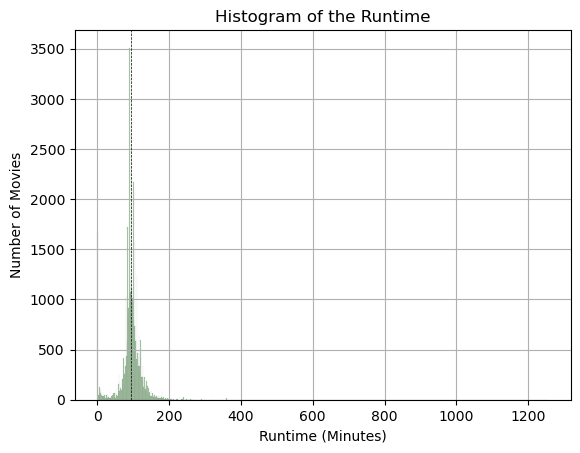

In [140]:
# Visualize the runtime distribution

# Use Freedman-Diaconis rule to determine number of bins
x_axis = "runtime"
iqr = np.percentile(cleaned_metadata_df[x_axis], 75) - np.percentile(cleaned_metadata_df[x_axis], 25)
bin_width = 2 * iqr / (len(cleaned_metadata_df[x_axis]) ** (1/3))
num_bins = int((cleaned_metadata_df[x_axis].max() - cleaned_metadata_df[x_axis].min()) / bin_width)

# Create the histogram of runtime
sns.histplot(data=cleaned_metadata_df, x=x_axis, bins=num_bins, color="darkseagreen")

# Label the histogram
plt.xlabel(x_axis.title() + " (Minutes)")
plt.ylabel('Number of Movies')
plt.title('Histogram of the ' + x_axis.title())
plt.grid()
plt.axvline(cleaned_metadata_df[x_axis].median(), color='k', linestyle='dashed', linewidth=0.5)

# Display plot
plt.show()

We also visualize the vote average distribution. The average votes range from 0 to 10. Apart from the spike of observations close to 0, which we believe are missing values, the data appears roughly normal with mean around 6. So, very highand very low average votes are less common.

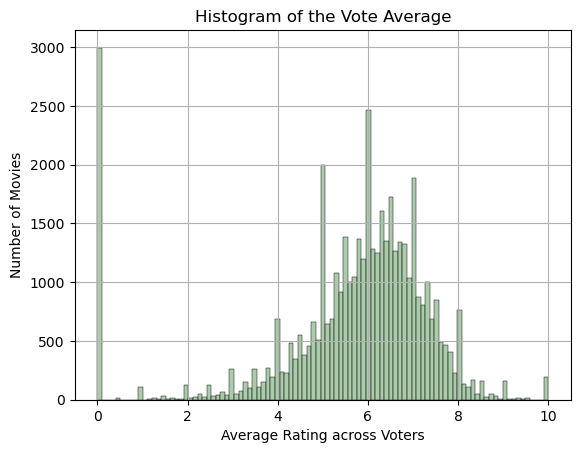

In [ ]:
# Visualize the vote average distribution

# Use Freedman-Diaconis rule to determine number of bins
x_axis = "vote_average"
iqr = np.percentile(cleaned_metadata_df[x_axis], 75) - np.percentile(cleaned_metadata_df[x_axis], 25)
bin_width = 2 * iqr / (len(cleaned_metadata_df[x_axis]) ** (1/3))
num_bins = int((cleaned_metadata_df[x_axis].max() - cleaned_metadata_df[x_axis].min()) / bin_width)

# Create the histogram of runtime
sns.histplot(data=cleaned_metadata_df, x=x_axis, bins=num_bins, color="darkseagreen")

# Label the histogram
plt.xlabel('Average Rating across Voters')
plt.ylabel('Number of Movies')
plt.title('Histogram of the Vote Average')
plt.grid()

# Display plot
plt.show()

Next, we move on to bivariate EDA. We explored all pairwise combinations of the numerical features to identify which would be the best to use for clustering in Study 2. Although none of the visualizations pointed to clear clusters, we identified the following combinations to be the most suitable:
- `budget` compared to `runtime`
- `popularity` compared to `runtime`

The scatterplots are shown below. There are a lot of 0 values for `budget` and `popularity`, which we believe are missing values, so we handle these in Study 2 when they are used.

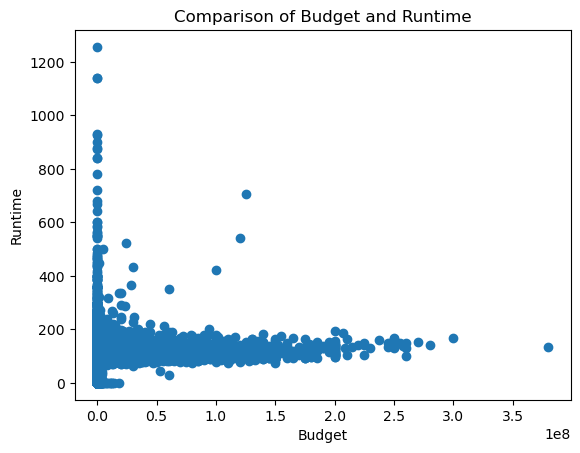

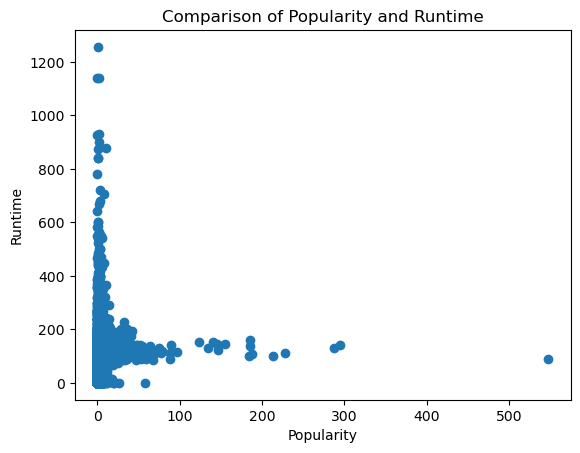

In [271]:
# Define a function to create the scatterplot
def scatterplot(feature1, feature2):
    plt.scatter(cleaned_metadata_df[feature1], cleaned_metadata_df[feature2])
    plt.xlabel(feature1.title())
    plt.ylabel(feature2.title())
    plt.title("Comparison of " + feature1.title() + " and " + feature2.title())
    plt.show()

# Create the scatterplots for the chosen attribute combinations
scatterplot("budget", "runtime")
scatterplot("popularity", "runtime")

### Cleaning and EDA of Ratings

We now perform cleaning and EDA on the ratings dataset.

#### Cleaning the Data

Note that we will reuse the defined functions in the metadata cleaning section.

##### Validity Check 1: Exact Duplicates

We will first check for exact duplicates in the dataset, verifying that there are no rows that are identical over all columns.

In [142]:
# Exact duplicates check

# Apply the .duplicated method to the DataFrame to create a Series, with exact duplicates set to True
# keep=False will mark all duplicates as True (including the first and last occurrences)
duplicates = ratings_df.duplicated(keep=False)

# Print the number of rows that are exact duplicates
print(f"Number of duplicate rows: {duplicates.sum()}\n")

Number of duplicate rows: 0



Since there are no duplicate rows, no cleaning is required.

##### Validity Check 2: Data Type Check

Next, we verify that the data stored is the correct data type using the data type check. The desired data type for each feature is:
- `userId`: int
- `movieId`: int
- `rating`: float
- `timestamp`: int

We will first use our `method 1` from `Assignment 2`, which checks if the data is already stored as the correct data type. We specify a dictionary, where the keys are the features, and the values are the desired data types. We iterate over each feature in the dictionary, applying the data type check to each.

In [244]:
# Data type check

# Create a dictionary that maps each attribute to its correct datatype
data_type_dict = {
    "userId": int,
    "movieId": int,
    "rating": float,
    "timestamp": int
}

# Apply the function to every feature, setting rows whose value is not stored as the correct datatype to True
for feature in data_type_dict.keys():
    invalid_datatype = ratings_df[feature].apply(
        lambda attribute: not type_filter_method1(attribute, data_type_dict[feature])
    )
    # Print the number of rows with a value that is not stored as the correct datatype for the designated attribute
    print(f"Number of rows where the {feature} value is not stored as the correct datatype ({data_type_dict[feature]}): {invalid_datatype.sum()}")

Number of rows where the userId value is not stored as the correct datatype (<class 'int'>): 0
Number of rows where the movieId value is not stored as the correct datatype (<class 'int'>): 0
Number of rows where the rating value is not stored as the correct datatype (<class 'float'>): 0
Number of rows where the timestamp value is not stored as the correct datatype (<class 'int'>): 0


Since all the data is stored as the correct data type, there is no cleaning to be done.

Note that Validity Check 3 (Format Errors) from the previous section does not apply here.

##### Validity Check 4: Presence Errors

Next, we check for presence errors, verifying that values are not missing in the any of the columns.

In [246]:
# Presence check

# Selected features
selected_features = ["userId", "movieId", "rating", "timestamp"]

# Iterate over each column and perform the presence check on each
for column in selected_features:
    # Apply pd.isna() to the test attribute, setting rows with missing values in the designated column to True
    invalid_presence = ratings_df[column].apply(pd.isna)

    # Print the number of rows with a missing value in the chosen test attribute
    print(f"Number of rows where the {column} value is missing: {invalid_presence.sum()}")

Number of rows where the userId value is missing: 0
Number of rows where the movieId value is missing: 0
Number of rows where the rating value is missing: 0
Number of rows where the timestamp value is missing: 0


None of the values are missing, so there is no cleaning to be done.

Note that Validity Check 5 (Uniqueness Errors) from the previous section does not apply here, as none of the attributes should have unique values.

Thus, we deduce that the ratings dataset is clean, and we conclude the data cleaning section.

#### Exploratory Data Analysis (EDA)

Next, we conduct EDA for the ratings dataset.

We begin by creating a countplot for the rating feature, from which we see that the ratings range from 0 to 5, in 0.5 increments. The most frequent rating is 4, and it appears that higher ratings (greater than 3) are more common than lower ratings. In particular, there are not a lot of 0.5 ratings.

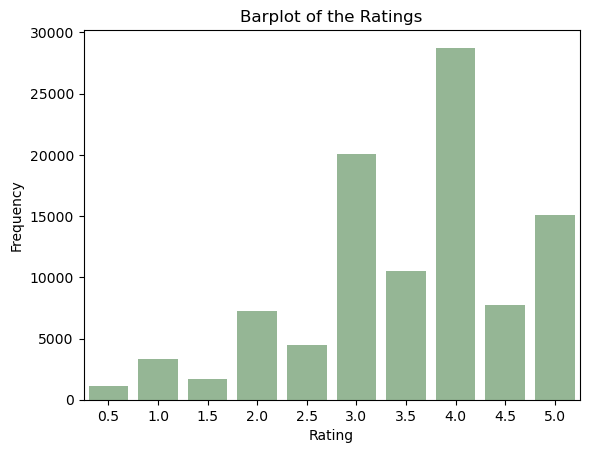

In [293]:
# Visualize the rating distribution

# Create the barplot of rating

sns.countplot(data=ratings_df, x='rating', color="darkseagreen")

# Label the histogram
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Barplot of the Ratings')

# Display plot
plt.show()

Next, we create a countplot for the movie IDs. The full countplot shows the overall distribution, with some movies rated almost 350 times, and others rated very few times. Since there are so many unique movie IDs in the dataset, we create another countplot of a sample of 20 movies. 18 of the 20 movies occur only once in the dataset, while 2 of the 20 occur twice.

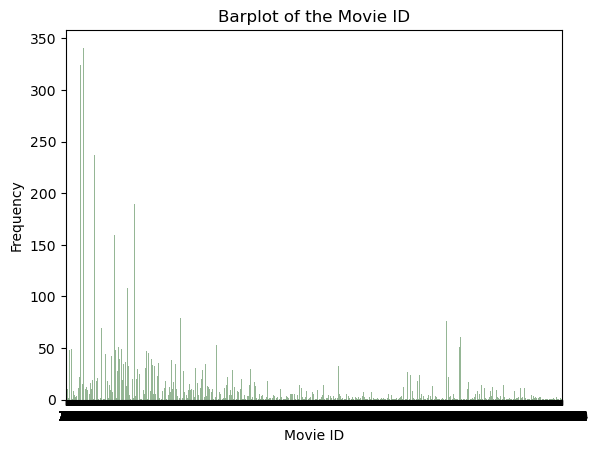

In [295]:
# Visualize the movie ID distribution

# Create the barplot of movie ID
sns.countplot(data=ratings_df, x='movieId', color="darkseagreen")

# Label the histogram
plt.xlabel('Movie ID')
plt.ylabel('Frequency')
plt.title('Barplot of the Movie ID')

# Display plot
plt.show()

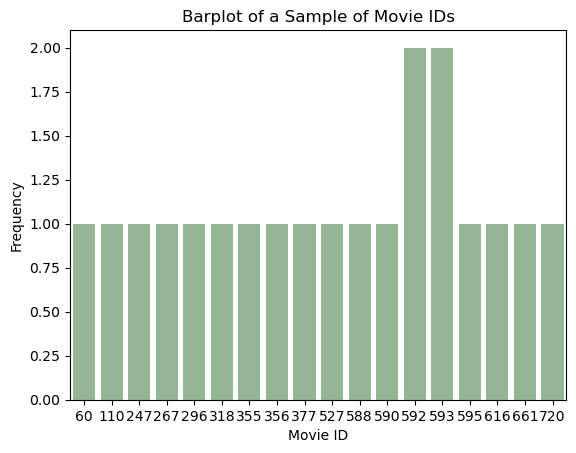

In [296]:
# Visualize the movie ID distribution

# Create the barplot of a sample of movie ID
sns.countplot(data=ratings_df[90:110], x='movieId', color="darkseagreen")

# Label the histogram
plt.xlabel('Movie ID')
plt.ylabel('Frequency')
plt.title('Barplot of a Sample of Movie IDs')

# Display plot
plt.show()

The countplot of the user ID is quite similar to the countplot of the movie ID, however, with generally larger frequencies. The highest frequency is almost 2500, and the most common frequency appears to be between 0 and 100.

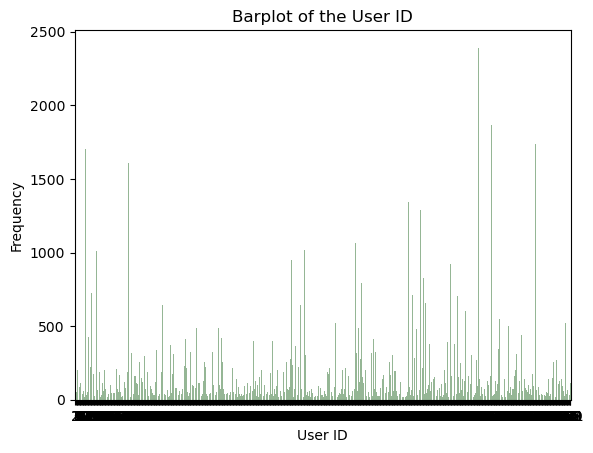

In [297]:
# Visualize the user ID distribution

# Create the barplot of user ID
sns.countplot(data=ratings_df, x='userId', color="darkseagreen")

# Label the histogram
plt.xlabel('User ID')
plt.ylabel('Frequency')
plt.title('Barplot of the User ID')

# Display plot
plt.show()

This concludes the EDA for the ratings data. Next, we begin the studies.

## Studies

### Study 1 — Similarity Measures

[desc]

#### Similarity Measure 1 — Jaccard Distance on Genres

[desc]

**References:** <br>
Similarity Overview: https://medium.com/@jodancker/a-brief-introduction-to-distance-measures-ac89cbd2298 <br>
Jaccard: https://stackoverflow.com/questions/46975929/how-can-i-calculate-the-jaccard-similarity-of-two-lists-containing-strings-in-py <br>
Sets: https://docs.python.org/3/tutorial/datastructures.html <br>
To List: https://pandas.pydata.org/docs/reference/api/pandas.Series.to_list.html <br>
Select columns: https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html <br>
Select specific rows: https://stackoverflow.com/questions/46380075/pandas-select-n-middle-rows <br>
Sort by feature: https://realpython.com/pandas-sort-python/

In [143]:
# Similarity measure 1 — Jaccard distance on Genres

# Select the reference movie
reference_movie = "Se7en"

def jaccard_similarity(list1, list2):
    # Convert the lists into sets
    set1 = set(list1)
    set2 = set(list2)

    # Find the size of the intersection
    intersection_size = len(set1 & set2)

    # Find the size of the union
    union_size = len(set1 | set2)

    # Handle empty case
    if union_size == 0:
        return 1

    # Compute and return jaccard distance
    return 1 - (intersection_size/union_size)

# Store the genres for the reference movie
reference_genres = cleaned_metadata_df[cleaned_metadata_df["original_title"]==reference_movie]["genres"].to_list()[0]

# Apply the function to the genres attribute, computing the Jaccard distance between the genres of the reference movie with every other movie
new_feature_name = "jaccard_genre_distance_to_" + reference_movie
cleaned_metadata_df[new_feature_name] = cleaned_metadata_df["genres"].apply(
    lambda genres: jaccard_similarity(reference_genres, genres)
)

# Print the genres of the reference movie
print(f"The genres of {reference_movie}: {reference_genres}\n")

# Print the five example rows
print(f"Examples of five rows with Jaccard distance to {reference_movie} based on the movie genres:")
cleaned_metadata_df[["original_title", "genres", new_feature_name]].head(10).tail(5)

The genres of Se7en: ['Crime', 'Mystery', 'Thriller']

Examples of five rows with Jaccard distance to Se7en based on the movie genres:


,original_title,genres,jaccard_genre_distance_to_Se7en
5,Heat,"[Action, Crime, Drama, Thriller]",0.6
6,Sabrina,"[Comedy, Romance]",1.0
7,Tom and Huck,"[Action, Adventure, Drama, Family]",1.0
8,Sudden Death,"[Action, Adventure, Thriller]",0.8
9,GoldenEye,"[Adventure, Action, Thriller]",0.8


[desc]

In [144]:
# Request: Show me the top 10 movies with the most similar genres as the reference movie
cleaned_metadata_df.loc[cleaned_metadata_df["original_title"] != reference_movie, ["original_title", "genres", new_feature_name]].sort_values(new_feature_name).head(10)

,original_title,genres,jaccard_genre_distance_to_Se7en
13193,La Chambre des morts,"[Mystery, Thriller, Crime]",0.0
12065,Eastern Promises,"[Thriller, Crime, Mystery]",0.0
23831,The Mystery of the 13th Guest,"[Thriller, Crime, Mystery]",0.0
29454,Beck 30 - Sjukhusmorden,"[Thriller, Crime, Mystery]",0.0
4051,The Mirror Crack'd,"[Crime, Thriller, Mystery]",0.0
4755,Domestic Disturbance,"[Mystery, Thriller, Crime]",0.0
8741,"Farewell, My Lovely","[Crime, Mystery, Thriller]",0.0
41711,"Kiss Me, Kill Me","[Mystery, Crime, Thriller]",0.0
33752,심야의 FM,"[Thriller, Crime, Mystery]",0.0
33576,The Boy Next Door,"[Crime, Mystery, Thriller]",0.0


[desc]

#### Similarity Measure 2 — Edit Distance on Title

[desc]

**References:** <br>
Levenshtein Distance: https://www.geeksforgeeks.org/introduction-to-python-levenshtein-module/ <br>

In [145]:
# Similarity Measure 2 — Edit Distance on Title

# Store the title used to compute the edit distance
reference_title = "Back to the Future"

# Apply the Levenshtein.distance function from the Levenshtein library to compute the edit distance between the reference title and the title of every other movie
new_feature_name = "edit_distance_title_to" + reference_title
cleaned_metadata_df[new_feature_name] = cleaned_metadata_df["original_title"].apply(
    lambda title: Levenshtein.distance(reference_title, title)
)

# Print the reference title
print(f"The reference title: {reference_title}\n")

# Print five example rows
print(f"Examples of five rows with edit distance to {reference_title} based on the movie title:")
cleaned_metadata_df[["original_title", new_feature_name]].head(5)

The reference title: Back to the Future

Examples of five rows with edit distance to Back to the Future based on the movie title:


,original_title,edit_distance_title_toBack to the Future
0,Toy Story,14
1,Jumanji,18
2,Grumpier Old Men,17
3,Waiting to Exhale,13
4,Father of the Bride Part II,19


[desc]

In [146]:
# Request: Show me the top 10 movies with a similar title to the reference movie
cleaned_metadata_df.loc[cleaned_metadata_df["original_title"] != reference_title, ["original_title", new_feature_name]].sort_values(new_feature_name).head(11).tail(10)

,original_title,edit_distance_title_toBack to the Future
21860,Back in the Saddle,7
30979,Back to the Jurassic,7
23537,Maps to the Stars,7
43818,Back to You and Me,8
39554,Back in the Day,8
23550,Back in the Day,8
37449,Back To The Sea,8
24299,Crimes of the Future,8
1902,Back to the Future Part II,8
21531,The Lost Future,8


[desc]

#### Similarity Measure 3 — Euclidean Distance on Revenue

[desc]

**References:** <br>
Euclidean Distance: https://www.w3schools.com/python/ref_math_dist.asp <br>

In [147]:
# Similarity Measure 3 — Euclidean Distance on Revenue

# Select the reference movie
reference_movie = "Pulp Fiction"

# Store the revenue for the reference movie
reference_revenue =  float(cleaned_metadata_df[cleaned_metadata_df["original_title"]==reference_movie]["revenue"].iloc[0])

# Apply the math.dist() function from the math library to compute the Euclidean distance between the revenue of the reference movie and the revenue of every other movie
new_feature_name = "euclidean_distance_revenue_to_" + reference_movie
cleaned_metadata_df[new_feature_name] = cleaned_metadata_df["revenue"].apply(
    lambda revenue: math.dist([reference_revenue], [revenue])
)

# Print the revenue of the reference movie
print(f"The revenue of {reference_movie}: {reference_revenue}\n")

# Print five example rows
print(f"Examples of five rows with Euclidean distance to {reference_movie} based on the movie revenue:")
cleaned_metadata_df[["original_title", "revenue", new_feature_name]].head(20).tail(5)

The revenue of Pulp Fiction: 213928762.0

Examples of five rows with Euclidean distance to Pulp Fiction based on the movie revenue:


,original_title,revenue,euclidean_distance_revenue_to_Pulp Fiction
15,Casino,116112375.0,97816387.0
16,Sense and Sensibility,135000000.0,78928762.0
17,Four Rooms,4300000.0,209628762.0
18,Ace Ventura: When Nature Calls,212385533.0,1543229.0
19,Money Train,35431113.0,178497649.0


[desc]

In [148]:
# Request: Show me the top 10 movies with a similar revenue to the reference movie
cleaned_metadata_df.loc[cleaned_metadata_df["original_title"] != reference_movie, ["original_title", "revenue", new_feature_name]].sort_values(new_feature_name).head(10)

,original_title,revenue,euclidean_distance_revenue_to_Pulp Fiction
1056,Dirty Dancing,213954274.0,25512.0
221,Disclosure,214015089.0,86327.0
5284,The Bourne Identity,214034224.0,105462.0
13847,Public Enemies,214104620.0,175858.0
3871,卧虎藏龙,213525736.0,403026.0
16818,Just Go with It,214918407.0,989645.0
25503,Into the Woods,212902372.0,1026390.0
13241,Bedtime Stories,212874442.0,1054320.0
5672,8 Mile,215000000.0,1071238.0
15483,The Sorcerer's Apprentice,215283742.0,1354980.0


[desc

#### Similarity Measure 4 — Manhattan Distance on Budget

[desc]

**References:** <br>
Manhattan Distance: https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cityblock.html <br>

In [149]:
# Similarity Measure 4 — Manhattan Distance on Budget

# Select the reference movie
reference_movie = "Interstellar"

# Store the budget for the reference movie
reference_budget =  float(cleaned_metadata_df[cleaned_metadata_df["original_title"]==reference_movie]["budget"].iloc[0])

# Apply the distance.cityblock() function from the scipy library to compute the Manhattan distance between the budget of the reference movie and the budget of every other movie
new_feature_name = "manhattan_distance_budget_to_" + reference_movie
cleaned_metadata_df[new_feature_name] = cleaned_metadata_df["budget"].apply(
    lambda budget: distance.cityblock([reference_budget], [budget])
)

# Print the budget of the reference movie
print(f"The budget of {reference_movie}: {reference_budget}\n")

# Print five example rows
print(f"Examples of five rows with Manhattan distance to {reference_movie} based on the movie budget:")
cleaned_metadata_df[["original_title", "budget", new_feature_name]].head(20).tail(5)

The budget of Interstellar: 165000000.0

Examples of five rows with Manhattan distance to Interstellar based on the movie budget:


,original_title,budget,manhattan_distance_budget_to_Interstellar
15,Casino,52000000.0,113000000.0
16,Sense and Sensibility,16500000.0,148500000.0
17,Four Rooms,4000000.0,161000000.0
18,Ace Ventura: When Nature Calls,30000000.0,135000000.0
19,Money Train,60000000.0,105000000.0


[desc]

In [150]:
# Request: Show me the top 10 movies with a similar budget to the reference movie
cleaned_metadata_df.loc[cleaned_metadata_df["original_title"] != reference_movie, ["original_title", "budget", new_feature_name]].sort_values(new_feature_name).head(10)

,original_title,budget,manhattan_distance_budget_to_Interstellar
8238,The Polar Express,165000000.0,0.0
30556,Independence Day: Resurgence,165000000.0,0.0
24455,Big Hero 6,165000000.0,0.0
15372,Shrek Forever After,165000000.0,0.0
19726,Wreck-It Ralph,165000000.0,0.0
26568,Doctor Strange,165000000.0,0.0
14984,How to Train Your Dragon,165000000.0,0.0
16492,Cowboys & Aliens,163000000.0,2000000.0
21941,Thor: The Dark World,170000000.0,5000000.0
23360,Godzilla,160000000.0,5000000.0


[desc]

#### Similarity Measure 5 — Sorensen-Dice Index on Production Companies

[desc]

**References:** <br>
Sorensen-Dice Index: https://medium.com/@jodancker/a-brief-introduction-to-distance-measures-ac89cbd2298

In [151]:
# Similarity Measure 5 — Sorensen-Dice Index on Production Companies

# Select the reference movie
reference_movie = "Big Hero 6"

def sorensen_dice_index(list1, list2):
    # Convert the lists into sets
    set1 = set(list1)
    set2 = set(list2)

    # Handle empty case
    if len(set1 | set2) == 0:
        return 1

    # Find the size of the intersection
    intersection_size = len(set1 & set2)

    # Find the size of set 1
    set1_size = len(set1)

    # Find the size of set 2
    set2_size = len(set2)

    return (2 * intersection_size) / (set1_size + set2_size)

# Store the production companies for the reference movie
reference_production_companies = cleaned_metadata_df[cleaned_metadata_df["original_title"]==reference_movie]["production_companies"].to_list()[0]

# Apply the function to the production companies attribute, computing the Sorensen Dice Index between the production companies of the reference movie with every other movie
new_feature_name = "sorensen_dice_index_with_" + reference_movie
cleaned_metadata_df[new_feature_name] = cleaned_metadata_df["production_companies"].apply(
    lambda production_companies: sorensen_dice_index(reference_production_companies, production_companies)
)

# Print the production companies of the reference movie
print(f"The production companies of {reference_movie}: {reference_production_companies}\n")

# Print the five example rows
print(f"Examples of five rows with sorensen dice index to {reference_movie} based on the movie production companies:")
cleaned_metadata_df[["original_title", "production_companies", new_feature_name]].head(10).tail(5)

The production companies of Big Hero 6: ['Walt disney pictures', 'Walt disney animation studios']

Examples of five rows with sorensen dice index to Big Hero 6 based on the movie production companies:


,original_title,production_companies,sorensen_dice_index_with_Big Hero 6
5,Heat,"[Regency enterprises, Forward pass, Warner bros.]",0.000000
6,Sabrina,"[Paramount pictures, Scott rudin productions, ...",0.000000
7,Tom and Huck,[Walt disney pictures],0.666667
8,Sudden Death,"[Universal pictures, Imperial entertainment, S...",0.000000
9,GoldenEye,"[United artists, Eon productions]",0.000000


[desc] - mention how this is the only similarity one, so we use descending instead of ascending

In [152]:
# Request: Show me the top 10 movies with the same production companies as the reference movie
cleaned_metadata_df.loc[cleaned_metadata_df["original_title"] != reference_movie, ["original_title", "production_companies", new_feature_name]].sort_values(new_feature_name, ascending=False).head(10)

,original_title,production_companies,sorensen_dice_index_with_Big Hero 6
31658,Feast,"[Walt disney pictures, Walt disney animation s...",1.0
40457,How to Hook Up Your Home Theater,"[Walt disney pictures, Walt disney animation s...",1.0
22110,Frozen,"[Walt disney pictures, Walt disney animation s...",1.0
21419,Planes,"[Walt disney pictures, Walt disney animation s...",1.0
36253,Zootopia,"[Walt disney pictures, Walt disney animation s...",1.0
19901,Paperman,"[Walt disney pictures, Walt disney animation s...",1.0
14496,The Princess and the Frog,"[Walt disney pictures, Walt disney animation s...",1.0
26089,Get a Horse!,"[Walt disney pictures, Walt disney animation s...",1.0
18830,The Ballad of Nessie,"[Walt disney pictures, Walt disney animation s...",1.0
41457,Moana,"[Walt disney pictures, Walt disney animation s...",1.0


[desc]

### Study 2 — Clustering Algorithms

**References:** <br>
Dropping missing data: https://www.statology.org/pandas-drop-rows-based-on-multiple-conditions/ <br>
KMeans tutorial: https://ai.plainenglish.io/performing-k-means-clustering-with-python-and-scikit-learn-f2f833841f69 <br>
KMeans documentation: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html <br>
Colours from labels: https://datascience.stackexchange.com/questions/122510/plot-clustered-data-by-kmeans-with-colors-for-clusters-and-shapes-for-external-l

In [153]:
def run_and_plot_minibatchkmeans(input_df, k_values, feature1, feature2):
    for k in k_values:
        # Fit MiniBatchKMeans with Scikit
        minibatchkmeans = MiniBatchKMeans(init='k-means++', n_clusters=k, n_init="auto", random_state=0)
        minibatchkmeans.fit(revenue_budget_metadata_df)
        
        # Predict the cluster for all movies
        P = minibatchkmeans.predict(revenue_budget_metadata_df)

        # Get the cluster labels for each data point, to be used for colours
        labels = minibatchkmeans.labels_
        
        # Generate scatter plot for training data
        colors = list(map(lambda x: '#3b4cc0' if x == 1 else '#b40426', P))
        plt.scatter(revenue_budget_metadata_df[feature1[0]], revenue_budget_metadata_df[feature2[0]], c=labels, marker="o", picker=True)
        plt.title(str(k) + ' Clusters of Data (' + feature1[0].title() + " vs " + feature2[0].title() + ")")
        plt.xlabel(feature1[0].title() + " (" + feature1[1] + ")")
        plt.ylabel(feature2[0].title() + " (" + feature2[1] + ")")
        plt.show()

In [154]:
# Save a DataFrame with the two desired features
feature1 = "budget"
feature2 = "runtime"
revenue_budget_metadata_df = cleaned_metadata_df[[feature1, feature2]]

# Drop all rows with missing data
revenue_budget_metadata_df = revenue_budget_metadata_df.loc[~((revenue_budget_metadata_df[feature1] == 0) | (revenue_budget_metadata_df[feature2] == 0))]

# Verify the updated DataFrame looks appropriate
revenue_budget_metadata_df["budget"].min()

1.0

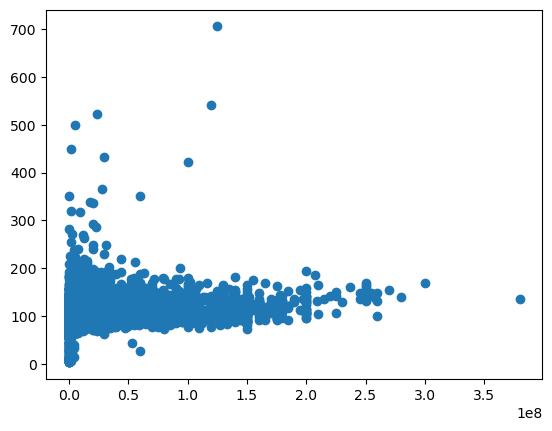

In [155]:
plt.scatter(revenue_budget_metadata_df[feature1], revenue_budget_metadata_df[feature2])
plt.show()

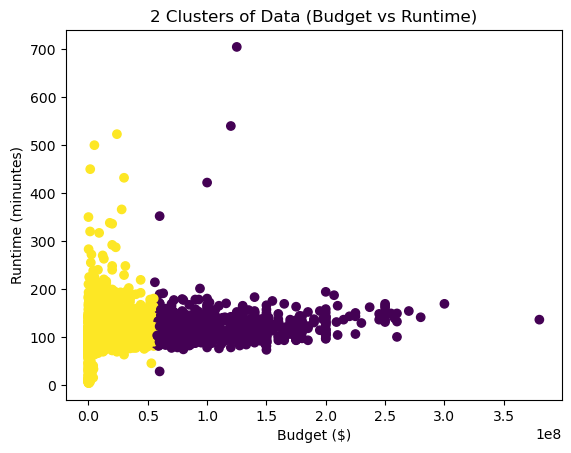

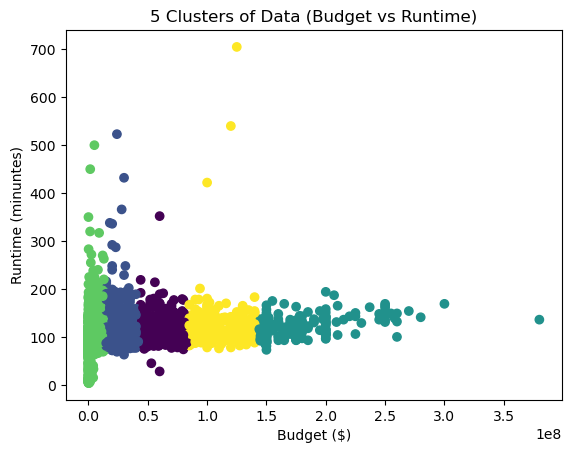

In [156]:
run_and_plot_minibatchkmeans(revenue_budget_metadata_df, [2, 5], ["budget", "$"], ["runtime", "minuntes"])

### Study 3 — Content-Based Recommendation System

In this study, we explore content-based recommendations using two heuristics.

The first similarity heuristic we use involves the genre, popularity and runtime of the movies, which we determined to be a suitable subset of features that users care about when looking for new movies. We use Jaccard distance on the movie genre, and Euclidean distance on the movie runtime and popularity, combining them using a weighted sum, where genre and popularity scores are weighted more heavily than the runtime score. We do this because, based on our knowledge of movies, we believe that the duration is not as important for a user. The smaller the distance, the more similar a movie is to the reference movie.

We proceed similarly for the second heuristic, however, we use a different subset of features (and corresponding similarity measures). The second similarity heuristic we use involves the title, production companies, and vote average. The title of a movie typically provides context on the topic of the movie, so we believe that this could be an interesting factor for recommending movies. However, movies with similar titles can still be vastly different, so we weight this factor lower than the others. Different production companies have different goals and methods, which influences the style of movies they produce. So, we believe that if a user enjoys a movie from some specific companies, it is likely than they will enjoy other movies from these companies. We use Sorensen-Dice Index to quantify the similarity, and we subtract its weight from 1 to quantify the distance (since the values are between 0 and 1). 
The vote average is another indicator of popularity, but based on user votes as opposed to TMBD's popularity score. If a user enjoys movies that were voted on highly, then they may be more likely to like other mainstream/highly-rated movies as well. Contrarily, if a user is looking for a movie with a lower vote average, then it is likely that this user is looking for movies that stray from the mainstream. We use Euclidean distance to quantify the distance in terms of vote average.

We use the functions for the similarity metrics defined in Study 1.

The three requests we choose to answer are:
- Show me movies similar to "Toy Story".
- Show me movies similar to "Dreamkiller".
- Show me movies similar to "Father of the Bride Part II".

**References:**<br>
To List: https://pandas.pydata.org/docs/reference/api/pandas.Series.to_list.html <br>
Sort: https://www.w3schools.com/python/pandas/ref_df_sort_values.asp <br>
Min/max: https://realpython.com/python-min-and-max/

In [227]:
# Implement the first heuristic
def heuristic1(reference_movie):
    # Store the genres for the reference movie
    reference_genres = cleaned_metadata_df[cleaned_metadata_df["title"]==reference_movie]["genres"].to_list()[0]
    # Apply the jaccard distance function to the genres attribute, computing distance between the genres of the reference movie with every other movie
    jaccard_genre = cleaned_metadata_df["genres"].apply(
        lambda genres: jaccard_similarity(reference_genres, genres)
    )
    # Store the popularity score for the reference movie
    reference_pop =  float(cleaned_metadata_df[cleaned_metadata_df["title"]==reference_movie]["popularity"].iloc[0])
    # Compute the Euclidean distance between the popularity scores of the reference movie with every other movie
    euc_pop = cleaned_metadata_df["popularity"].apply(
        lambda pop: math.dist([reference_pop], [pop])
    )
    # Store the runtime for the reference movie
    reference_run =  float(cleaned_metadata_df[cleaned_metadata_df["title"]==reference_movie]["runtime"].iloc[0])
    # Compute the Euclidean distance between the runtime scores of the reference movie with every other movie
    # Note that we compute this separately from the popularity because we weight them differently
    euc_run = cleaned_metadata_df["runtime"].apply(
        lambda run: math.dist([reference_run], [run])
    )
    # Normalize popularity and runtime distances
    euc_pop_normalized = (euc_pop - euc_pop.min()) / (euc_pop.max() - euc_pop.min())
    euc_run_normalized = (euc_run - euc_run.min()) / (euc_run.max() - euc_run.min())
    # Take the weighted sum
    attribute_name = "heuristic1_distance_to_" + reference_movie
    cleaned_metadata_df[attribute_name] = 2*jaccard_genre + 2*euc_pop_normalized + 1*euc_run_normalized
    # Select the top ten results
    return(cleaned_metadata_df.sort_values(by=attribute_name).head(10), attribute_name)

In [234]:
# Implement the second heuristic
def heuristic2(reference_movie):
    # Apply the edit distance to the title attribute, computing distance between the title of the reference movie with every other movie
    edit_title = cleaned_metadata_df[new_feature_name] = cleaned_metadata_df["title"].apply(
        lambda title: Levenshtein.distance(reference_movie, title)
    )
    # Store the production companies for the reference movie
    reference_companies = cleaned_metadata_df[cleaned_metadata_df["title"]==reference_movie]["production_companies"].to_list()[0]
    # Apply the Sorensen-Dice Index function to the companies attribute, computing distance between the companies of the reference movie with every other movie
    sd_index_company = cleaned_metadata_df["production_companies"].apply(
        lambda companies: sorensen_dice_index(reference_companies, companies)
    )
    sd_index_company = 1 - sd_index_company
    # Store the budget for the reference movie
    reference_vote =  float(cleaned_metadata_df[cleaned_metadata_df["title"]==reference_movie]["vote_average"].iloc[0])
    # Compute the Euclidean distance between the popularity scores of the reference movie with every other movie
    euc_vote = cleaned_metadata_df["vote_average"].apply(
        lambda vote: math.dist([reference_vote], [vote])
    )
    # Normalize title and budget distances to be between 0 and 1
    euc_vote_normalized = (euc_vote - euc_vote.min()) / (euc_vote.max() - euc_vote.min())
    edit_title_normalized = (edit_title - edit_title.min()) / (edit_title.max() - edit_title.min())
    # Take the weighted sum
    attribute_name = "heuristic2_distance_to_" + reference_movie
    cleaned_metadata_df[attribute_name] = 1*edit_title_normalized + 2*sd_index_company + 2*euc_vote_normalized
    # Select the top ten results
    return(cleaned_metadata_df.sort_values(by=attribute_name).head(10), attribute_name)

Now that we have implemented both heuristics, we test them on our sample requests. For each request, we display the attributes involved in the first heuristic (genres, popularity and runtime) and all the attributes involved in the second heuristic (title, production companies and vote average), to allow for a more thorough comparison between the two methods.

In [232]:
heuristic1_1, attribute_name = heuristic1("Toy Story")
heuristic1_1[['title', 'genres', 'popularity', 'runtime', 'production_companies', 'vote_average', attribute_name]]

,title,genres,popularity,runtime,production_companies,vote_average,heuristic1_distance_to_Toy Story
0,Toy Story,"[Animation, Comedy, Family]",21.946943,81.0,[Pixar animation studios],7.7,0.000000
10520,Chicken Little,"[Animation, Family, Comedy]",18.584609,81.0,"[Walt disney pictures, Walt disney feature ani...",5.6,0.012796
21161,Despicable Me 2,"[Animation, Comedy, Family]",24.823550,98.0,"[Universal pictures, Illumination entertainment]",7.0,0.025415
2997,Toy Story 2,"[Animation, Comedy, Family]",17.547693,92.0,[Pixar animation studios],7.3,0.026103
4756,"Monsters, Inc.","[Animation, Comedy, Family]",26.419962,92.0,"[Walt disney pictures, Pixar animation studios]",7.5,0.026384
11959,The Simpsons Movie,"[Animation, Comedy, Family]",14.302911,87.0,"[Gracie films, Twentieth century fox film corp...",6.9,0.034197
15348,Toy Story 3,"[Animation, Family, Comedy]",16.966470,103.0,"[Walt disney pictures, Pixar animation studios]",7.6,0.037677
6795,Looney Tunes: Back in Action,"[Animation, Comedy, Family]",13.666488,90.0,"[Lonely film productions gmbh & co. kg., Warne...",5.6,0.039172
21780,Cloudy with a Chance of Meatballs 2,"[Animation, Family, Comedy]",14.412061,95.0,"[Columbia pictures, Sony]",6.4,0.040590
3629,Chicken Run,"[Animation, Comedy, Family]",11.834245,84.0,"[Dreamworks skg, Aardman animations, Dreamwork...",6.5,0.041038


In [235]:
heuristic2_1, attribute_name = heuristic2("Toy Story")
heuristic2_1[['title', 'genres', 'popularity', 'runtime', 'production_companies', 'vote_average', attribute_name]]

,title,genres,popularity,runtime,production_companies,vote_average,heuristic2_distance_to_Toy Story
0,Toy Story,"[Animation, Comedy, Family]",21.946943,81.0,[Pixar animation studios],7.7,0.000000
18182,Lifted,[Animation],5.767577,5.0,[Pixar animation studios],7.6,0.106782
13724,Up,"[Animation, Comedy, Family, Adventure]",19.330884,96.0,[Pixar animation studios],7.8,0.116883
16873,BURN·E,"[Animation, Family]",8.003898,8.0,[Pixar animation studios],7.8,0.116883
2997,Toy Story 2,"[Animation, Comedy, Family]",17.547693,92.0,[Pixar animation studios],7.3,0.124098
19169,Geri's Game,"[Animation, Family]",4.768849,4.0,[Pixar animation studios],7.8,0.137085
14411,Partly Cloudy,"[Animation, Family]",12.916643,5.0,[Pixar animation studios],7.9,0.142857
6232,Finding Nemo,"[Animation, Family]",25.497794,100.0,[Pixar animation studios],7.6,0.147186
19101,Presto,"[Animation, Family]",8.563861,5.0,[Pixar animation studios],8.0,0.148629
19216,For the Birds,"[Animation, Family]",11.209398,3.0,[Pixar animation studios],7.5,0.152958


As expected, for both heuristics, "Toy Story" is ranked first (as it is the most similar to itself). The only other movie that both heuristics recommended was "Toy Story 2", which we can tell qualitatively is evidently relevant as a recommendation. However, both heuristics recommend similar types of movies, specifically animated children's movies.

The first heuristic recommends movies "Chicken Little" and "Despicable Me 2", as an example. All movies recommended by the first heuristic are popular (which is expected as popularity is a factor in the heuristic), and have genres animation, comedy and family. Moreover, all the movies are feature films, with fairly standard movie lengths (as "Toy Story" has). So, if the user wanted well-known funny family movies, this heuristic would be better.

The second heuristic recommends movies "Lifted" and "Up", for example. "Up" is a popular movie, however, "Lifted" is not. Both are rated quite highly by users. Moreover, all the movies recommended by the second heuristic are made by Pixar. The runtimes of the movies recommended vary a lot, as opposed to the previous heuristic, showing that this heuristic provides a lot of short films as well. Interestingly, despite this heuristic accounting for the title, it does not recommend "Toy Story 3", which has a very similar title, but the first heuristic (which does not account for the title) does. This potentially shows the impact of putting a lower weight on the title factor, as the other factors in the heuristic take priority. Moreover, despite not accounting for genre, the majority of genres are animation and family, and there are no movies from genres outside of the genres of "Toy Story". So, the second heuristic is also effective at making recommendations, and we believe it is more geared towards users interested specifically in Pixar films and more niche movies.

Overall, we believe that the recommendations of the first heuristic are more general and likely to appeal to someone who liked "Toy Story", so we choose the first heuristic. However, as we described before, both are useful in different scenarios.


In [239]:
heuristic1_2, attribute_name = heuristic1("Dreamkiller")
heuristic1_2[['title', 'genres', 'popularity', 'runtime', 'production_companies', 'vote_average', attribute_name]]

,title,genres,popularity,runtime,production_companies,vote_average,heuristic1_distance_to_Dreamkiller
17382,Dreamkiller,"[Mystery, Thriller]",0.035294,110.0,[],5.0,0.000000
29429,Lady in White,"[Mystery, Thriller]",0.110590,110.0,[Sandrews],6.0,0.000275
39378,Steel Cold Winter,"[Thriller, Mystery]",0.725267,110.0,"[Blossom films, Vanguard studio]",6.6,0.002521
43164,The Devotion of Suspect X,"[Mystery, Thriller]",0.248070,112.0,[Beijing enlight pictures],8.0,0.002523
13261,Blackout,"[Thriller, Mystery]",0.411949,108.0,[Filmiteollisuus fine],6.7,0.003121
5524,Shamus,"[Mystery, Thriller]",0.674968,106.0,[Columbia pictures corporation],7.6,0.005827
29359,Death Walks on High Heels,"[Mystery, Thriller]",1.264036,108.0,"[Atlántida films, Cinecompany]",6.7,0.006234
42535,Pornography: A Thriller,"[Thriller, Mystery]",0.631991,115.0,[Triple fire productions],5.2,0.006543
18053,End of the Game,"[Mystery, Thriller]",0.893905,106.0,"[Mfg-film, T.r.a.c.]",5.7,0.006627
37110,The Girl in the Yellow Pajamas,"[Mystery, Thriller]",0.271397,103.0,"[Zodiac produzioni, Producciones internacional...",6.8,0.006971


In [237]:
heuristic2_2, attribute_name = heuristic2("Dreamkiller")
heuristic2_2[['title', 'genres', 'popularity', 'runtime', 'production_companies', 'vote_average', attribute_name]]

,title,genres,popularity,runtime,production_companies,vote_average,heuristic2_distance_to_Dreamkiller
17382,Dreamkiller,"[Mystery, Thriller]",0.035294,110.0,[],5.0,0.000000
17176,Dealer,[Drama],0.457814,136.0,[],5.0,0.051546
38587,The Builder,[],0.057648,94.0,[],5.0,0.061856
37297,Despiser,[],0.283510,105.0,[],5.0,0.061856
6726,Dopamine,"[Comedy, Romance]",0.401575,79.0,[],5.0,0.061856
39500,Webmaster,[Science fiction],0.478260,97.0,[],5.0,0.072165
41561,Deal,[],0.276021,87.0,[],5.0,0.072165
30138,Dazzle,"[Fantasy, Family]",0.650763,85.0,[],5.0,0.072165
18700,Deserter,[],0.115836,0.0,[],5.0,0.072165
29021,Born Killers,"[Action, Thriller]",0.474015,87.0,[],5.0,0.072165


The only movie that both heuristics recommend is "Dreamkiller", which is unsurprisingly ranked first. In this case, the recommendations from both heuristics seem fairly different.

It appears (qualitatively) that the second heuristic does not perform as well as the first. For example, it recommends "Dopamine", which is a fairly popular comedy romance movie, that does not seem similar to "Dreamkiller". Since the movie "Dreamkiller" does not have any production companies listed, instead of finding movies with the same production companies, we find other movies without companies listed, which are not necessarily similar. This demonstrates how the heuristic methods are sensitive to missing data. Moreover, the vote average is 5, which is a fairly central value, meaning that it does not provide us with a lot of information about the preferences of the user. So, in this case, we believe the features used in the second heuristic were not suitable for this case.

The first heuristic, on the other hand, recommends other mystery thriller movies, that are obscure (low popularity scores) and are feature films (standard movie length). These movies all appear to be similar to "Dreamkiller" and we believe that they would be useful for users making this request.

In [240]:
heuristic1_3, attribute_name = heuristic1("Father of the Bride Part II")
heuristic1_3[['title', 'genres', 'popularity', 'runtime', 'production_companies', 'vote_average', attribute_name]]

,title,genres,popularity,runtime,production_companies,vote_average,heuristic1_distance_to_Father of the Bride Part II
4,Father of the Bride Part II,[Comedy],8.387519,106.0,"[Sandollar productions, Touchstone pictures]",5.7,0.000000
3386,The Odd Couple,[Comedy],8.353900,106.0,[Paramount pictures],7.5,0.000125
8834,To Be or Not to Be,[Comedy],8.378174,107.0,"[Twentieth century fox film corporation, Brook...",7.0,0.000904
8968,Dutch,[Comedy],8.237799,107.0,"[Twentieth century fox film corporation, Hughe...",6.4,0.001425
41471,Office Christmas Party,[Comedy],8.228918,105.0,"[Paramount pictures, Dreamworks skg, Dreamwork...",5.4,0.001458
1755,Major League: Back to the Minors,[Comedy],8.207548,107.0,"[Warner bros., Morgan creek productions]",4.3,0.001537
17137,Nothing to Declare,[Comedy],8.371842,108.0,"[Scope invest, Tf1 films production, Canal+, C...",5.7,0.001797
30114,The Taming of the Scoundrel,[Comedy],8.544678,104.0,[Capital film],7.0,0.002322
9056,Major League II,[Comedy],7.989181,105.0,"[Warner bros., Morgan creek productions]",5.2,0.002347
2256,Desperately Seeking Susan,[Comedy],8.679349,104.0,[Orion pictures],6.0,0.002822


In [241]:
heuristic2_3, attribute_name = heuristic2("Father of the Bride Part II")
heuristic2_3[['title', 'genres', 'popularity', 'runtime', 'production_companies', 'vote_average', attribute_name]]

,title,genres,popularity,runtime,production_companies,vote_average,heuristic2_distance_to_Father of the Bride Part II
4,Father of the Bride Part II,[Comedy],8.387519,106.0,"[Sandollar productions, Touchstone pictures]",5.7,0.000000
6793,Father of the Bride,"[Comedy, Romance]",5.490622,105.0,"[Sandollar productions, Touchstone pictures]",6.2,0.267393
4471,Gross Anatomy,"[Comedy, Drama, Romance]",4.506924,109.0,"[Sandollar productions, Touchstone pictures]",5.9,0.323049
43337,True Identity,[Comedy],0.815294,93.0,"[Sandollar productions, Touchstone pictures]",6.1,0.381730
3063,Play It to the Bone,"[Comedy, Drama]",4.347609,124.0,[Touchstone pictures],5.7,0.885057
5552,Billy Bathgate,"[Drama, Action, Thriller, Crime]",3.846331,106.0,[Touchstone pictures],5.7,0.919540
531,A Simple Twist of Fate,"[Drama, Family]",4.135160,106.0,[Touchstone pictures],5.7,0.919540
2359,Tough Guys,"[Comedy, Crime]",2.860840,104.0,[Touchstone pictures],5.7,0.942529
4359,Cocktail,"[Drama, Romance]",9.270831,104.0,[Touchstone pictures],5.7,0.942529
710,Last Dance,"[Drama, Thriller]",1.196686,103.0,[Touchstone pictures],5.6,0.966122


Once again, the only movie that both heuristics recommend is "Father of the Bride Part II", which is unsurprisingly ranked first. In this case, the recommendations from both heuristics seem fairly similar.

Despite the second heuristic not accounting for genres, it mostly recommends comedy movies. Similarly, despite not accounting for runtime, it recommends movies that are of similar length (all feature films). There are a couple movies which seem irrelevant, such as "Last Dance", which is about a woman on death row. However, there are also highly relevant movies such as "Father of the Bride" and "Gross Anatomy".

The first heuristic provides comedy movies, but they are not as tailored to "Father of the Bride Part II" as the second heuristic recommendations. As opposed to the last two movies, "Father of the Bride Part II" is only listed under a single genre, meaning that there is less nuance in detecting similar movies with respect to the genre. For example, "Father of the Bride Part II" leans towards the heartfelt, character-driven style of comedy, while movies such as "Major League II" and "Dutch" are more in line with exaggerated humor.

Thus, in this case, we believe the second heuristic is more suitable.


Overall, both heuristics offer unique advantages that make them useful in different scenarios. However, in a general sense, we believe that the first heuristic is more useful, as the factors it uses are more representative of a user's likes. That being said, the heuristics often recommended similar types of movies despite using entirely different factors.

### Study 4 — Collaborate Filtering Recommendation System

In this study, we explore collaborative filtering to make recommendations.

We begin by separating 10% of the data to use as a gold standard to evaluate our performance at a later step.

**References:** <br>
Test train split: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html <br>

In [ ]:
# Reserve 10% of the data to for evaluation
# Use random sampling to ensure that the gold standard contains data about various users and movies
train, gold_standard = train_test_split(ratings_df, test_size = 0.1, random_state = 1)
print(train.shape)
print(gold_standard.shape)

(90003, 4)
(10001, 4)


Next, we create the utility matrix using the train portion of the ratings data. The utility matrix stores every user's rating for every movie they've seen. Every row represents a distinct user and every column represents a distinct movie. The matrix is quite sparse because every user only rates a subset of movies. From the EDA, we know that the majority of users appear in the dataset less than 100 times, meaning that they have rated less than 100 movies. So, the majority of rows would be null for at least 89903 columns, corresponding to the unrated movies for that user.

**References:** <br>
Pivot table: https://www.geeksforgeeks.org/python-pandas-pivot_table/

In [ ]:
# Create the utility matrix: a matrix where the rows represent users and the columns represent movies
# The entries are the rating for the corresponding movie given by the corresponding user
R = pd.pivot_table(train, values='rating', index='userId', columns = 'movieId')

# Output some sample entries of the matrix
R.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Although the utility matrix above is in the correct format, the library we use to perform the matrix factorization requires an Iteractions object as input, which consists of triplets of the form (user ID, movie ID, rating). So, we create this object with the train portion of the training data.

**References:** <br>
Interactions: https://maciejkula.github.io/spotlight/interactions.html#spotlight.interactions.Interactions

In [298]:
# The input to the model must be an Interaction object with triplets (userId, movieId, rating)
# So, we create a version of the utility matrix that is in the format expected for the model
R_input = Interactions(
    np.array(train["userId"]),
    np.array(train["movieId"]),
    np.array(train["rating"])
)

We continue by performing the matrix factorization, using the `Spotlight` library. It uses gradient descent and backpropagation to create latent vectors for the users and the movies, from which we can apply the dot product to predict a rating for a specific user and movie. We test three different latent dimensions: 10 (low number of latent dimensions), 32 (default number of latent dimensions for the library) and 100 (high number of latent dimensions). We expect that with a higher number of latent dimensions, the model can capture more information, leading to better predictions. However, there is also the possibility of overfitting due to the increased flexibility, meaning that the predictions would be worse on unseen, or in our case, hidden data. With a lower number of latent dimensions, we expect that the model cannot capture as much information, leading to less informed predictions. However, it is possible that the model is able to generalize better.

**References:** <br>
Spotlight: https://maciejkula.github.io/spotlight/ <br>
Spotlight explicit factorization: https://maciejkula.github.io/spotlight/factorization/explicit.html <br>
Spotlight explicit factorization code: https://maciejkula.github.io/spotlight/_modules/spotlight/factorization/explicit.html#ExplicitFactorizationModel.fit <br>
Ensuring reproducibility: https://pytorch.org/docs/stable/notes/randomness.html

In [ ]:
# Set the random state to allow for reproducibility
rand_state = np.random.RandomState(23)

def set_seed(seed=23):
    # Set numpy seed
    np.random.seed(seed)  
    # Set the random number generator for both cpu and cuda      
    torch.manual_seed(seed)
    # Set the cuda seed
    torch.cuda.manual_seed_all(seed) 
    # Causes pytorch to perform deterministically
    torch.backends.cudnn.deterministic = True 
    # Causes the cuDNN library, which is used by cuda, to perform deterministically
    torch.backends.cudnn.benchmark = False 

def matrix_factorization(latent_dim = 32):
    set_seed(23)
    # Define the model that performs matrix factorization
    factorization = ExplicitFactorizationModel(n_iter=10, embedding_dim=latent_dim, 
                                               use_cuda=gpu_status, random_state=rand_state)
    # Fit the model to our data
    factorization.fit(R_input)
    return(factorization)

In [311]:
# Test different latent dimensions, which is represented by `embedding_dim`
# The default for number of latent dimensions is 32
factorization_lower_latent = matrix_factorization(10)
factorization_higher_latent = matrix_factorization(100)
factorization = matrix_factorization()

Next, we simulate requests for three sample users, for each of them generating 10 movies that they haven't seen before but that we believe they would have rated highly.

**References:**<br>
Difference between arrays: https://numpy.org/devdocs/reference/generated/numpy.setdiff1d.html <br>
Spotlight explicit factorization: https://maciejkula.github.io/spotlight/factorization/explicit.html <br>
Sort values: https://www.w3schools.com/python/pandas/ref_df_sort_values.asp

In [321]:
# Simulate three requests for movies a user would have rated highly but hasn't seen yet
# Note: feel free to change the user IDs to experiment with different users
sample_user_1 = 1
sample_user_2 = 655
sample_user_3 = 303

def requests(user, X):
    # Obtain an array of all the unique movie IDs
    unique_movies = train['movieId'].unique()
    # Obtain an array of all the movie IDs corresponding to movies that the user has rated in the past
    already_rated_movies = train[train['userId'] == user]['movieId']
    # Take their difference to obtain the movies that the user has not yet rated
    unrated_movies = np.setdiff1d(unique_movies, already_rated_movies)
    # Predict the rankings for those movies and the given user
    rankings = factorization.predict(user, unrated_movies)
    # Save the movies along with their predicted ratings
    unrated_movie_predictions = pd.DataFrame({'movieId': unrated_movies, 'predicted_rank': rankings})
    # Return a dataframe containing the movie IDs with the top 10 predicted ratings
    return(unrated_movie_predictions.sort_values(by='predicted_rank', ascending=False))[:X]

# Output the results for sample request 1
pred_user_1 = requests(sample_user_1, 10)
print(f"Recommendations for user {sample_user_1}")
pred_user_1

Recommendations for user 1


,movieId,predicted_rank
1074,1353,5.548332
3756,4958,5.142284
4756,6957,4.834958
3166,4029,4.775405
1019,1286,4.702222
726,915,4.588935
1449,1918,4.517878
816,1025,4.448325
1454,1923,4.370315
3095,3949,4.320394


In [322]:
# Output the movie titles corresponding to these recommendations
for movie_id in pred_user_1['movieId']:
    title = metadata_df.loc[metadata_df['id'] == str(movie_id), 'title']
    if not title.empty:
        print(title.values[0])
    else:
        print(f"No title found for movie ID {movie_id}")

No title found for movie ID 1353
The Legend of Bagger Vance
The 40 Year Old Virgin
No title found for movie ID 4029
No title found for movie ID 1286
No title found for movie ID 915
Or (My Treasure)
No title found for movie ID 1025
Twin Peaks: Fire Walk with Me
No title found for movie ID 3949


So, for user 1, the default model (latent dimension 32) recommends movies like "The Legend of Bagger Vance" and "The 40 Year Old Virgin".

In [323]:
# Output the results for sample request 2
pred_user_2 = requests(sample_user_2, 10)
print(f"Recommendations for user {sample_user_2}")
pred_user_2

Recommendations for user 655


,movieId,predicted_rank
3688,4914,6.285997
6753,62956,6.080751
3070,3963,6.075068
986,1273,6.033704
2473,3181,6.028378
884,1148,6.007240
2862,3706,5.977178
1774,2318,5.950414
6715,61323,5.916158
885,1150,5.863713


In [324]:
# Output the movie titles corresponding to these recommendations
for movie_id in pred_user_2['movieId']:
    title = metadata_df.loc[metadata_df['id'] == str(movie_id), 'title']
    if not title.empty:
        print(title.values[0])
    else:
        print(f"No title found for movie ID {movie_id}")

No title found for movie ID 4914
Very Annie Mary
No title found for movie ID 3963
TMNT
No title found for movie ID 3181
No title found for movie ID 1148
No title found for movie ID 3706
No title found for movie ID 2318
No title found for movie ID 61323
No title found for movie ID 1150


So, for user 2, the default model (latent dimension 32) recommends movies like "Very Annie Mary".

In [305]:
# Output the results for sample request 3
pred_user_3 = requests(sample_user_3, 10)
print(f"Recommendations for user {sample_user_3}")
pred_user_3

Recommendations for user 303


,movieId,predicted_rank
4596,6936,5.453159
3904,5464,5.354078
942,1273,5.255180
6624,61323,5.206323
5921,40629,5.130174
27,28,5.105903
6145,48304,5.076051
4606,6957,5.068310
954,1286,5.013644
4678,7063,4.981901


In [326]:
# Output the movie titles corresponding to these recommendations
for movie_id in pred_user_3['movieId']:
    title = metadata_df.loc[metadata_df['id'] == str(movie_id), 'title']
    if not title.empty:
        print(title.values[0])
    else:
        print(f"No title found for movie ID {movie_id}")

Ben X
No title found for movie ID 5464
TMNT
No title found for movie ID 61323
The Mikado
Apocalypse Now
No title found for movie ID 48304
The 40 Year Old Virgin
No title found for movie ID 1286
No title found for movie ID 7063


So, for user 3, the default model (latent dimension 32) recommends movies like "Ben X" and "The 40 Year Old Virgin".

Finally, we move to quantitative evaluation using the gold standard.

**References:**<br>
Spotlight explicit factorization: https://maciejkula.github.io/spotlight/factorization/explicit.html <br>

In [327]:
# Select the user and movie ids from the gold standard
user_ids = np.array(gold_standard["userId"])
movie_ids = np.array(gold_standard["movieId"])

def make_pred(model, tag=""):
    # Predict the rating for these user and movie pairs using the dot product
    predictions = model.predict(user_ids, movie_ids)
    # Save the predictions in the dataframe
    attribute_name = "prediction" + tag
    gold_standard[attribute_name] = predictions

# Make the predictions
make_pred(factorization)
make_pred(factorization_higher_latent, "_higher_latent")
make_pred(factorization_lower_latent, "_lower_latent")

# Display some of the predictions
gold_standard.tail()

,userId,movieId,rating,timestamp,prediction,prediction_higher_latent,prediction_lower_latent,relevance
75114,521,4226,4.0,1370072767,4.064188,4.342930,4.804881,1
64116,461,163,3.0,1090907465,3.001827,2.625527,3.106210,0
50050,367,2692,3.5,1128632819,3.544749,4.683850,3.738105,0
66384,468,4299,2.5,1296197927,2.082593,1.503828,1.161221,0
2239,15,55765,2.0,1361078252,3.105034,2.706158,2.292956,0


We can already observe slight differences in the predicted rankings based on the latency of the model. We quantify these differents in the next part, beginning with calculating the mean squared error (MSE).

In [328]:
# Evaluation 1: Calculate MSE
def MSE(pred, true):
    return np.mean((true-pred)**2)

# Calculate MSE for the default model
ratings_MSE = MSE(gold_standard['prediction'], gold_standard['rating'])
print(f"MSE of predictions using default latent dimensions: {ratings_MSE}")

# Calculate MSE for the high latent dim model
ratings_MSE_higher_latent = MSE(gold_standard['prediction_higher_latent'], gold_standard['rating'])
print(f"MSE of predictions using higher number of latent dimensions: {ratings_MSE_higher_latent}")

# Calculate MSE for the low latent dim model
ratings_MSE_lower_latent = MSE(gold_standard['prediction_lower_latent'], gold_standard['rating'])
print(f"MSE of predictions using lower number of latent dimensions: {ratings_MSE_lower_latent}")

MSE of predictions using default latent dimensions: 1.2065921995700097
MSE of predictions using higher number of latent dimensions: 1.0908017344418712
MSE of predictions using lower number of latent dimensions: 1.0848970565532579


We observe that the models with higher (100) and lower (10) latent dimensions perform very similarly, and both better than the default model, which is unexpected. It is possible that the default model got stuck in a local minima, as the factorization uses gradient descent.

Overall, the values of MSE are all quite reasonable.

We also compute the precision at 5 and 10 (P@5 and P@10 respectively), and the mean reciprocal rank (MRR).

**References:** <br>
P@K: https://uottawa.brightspace.com/d2l/le/content/490358/viewContent/6685023/View (Slide 56) <br>
MRR: https://uottawa.brightspace.com/d2l/le/content/490358/viewContent/6685023/View (Slide 58) <br>
MRR when there are no relevant items: https://www.evidentlyai.com/ranking-metrics/mean-reciprocal-rank-mrr

In [329]:
# Evaluation 2:
# Set a movie as relevant or not
def relevant(score):
    # A movie is relevant if it has a score of 4 or more
    if score >= 4:
        return 1
    else:
        return 0
# Create an attribute for relevance
gold_standard["relevance"] = gold_standard['rating'].apply(relevant)
gold_standard.head()

,userId,movieId,rating,timestamp,prediction,prediction_higher_latent,prediction_lower_latent,relevance
99778,667,446,4.0,847271818,3.040505,4.804563,4.720907,1
16170,104,71135,3.5,1446674062,3.863858,2.433599,3.905639,0
3521,19,1394,5.0,855192061,4.693162,3.891190,3.380929,1
55070,395,671,5.0,953007109,1.340841,2.397732,2.418098,1
25477,187,953,3.0,1230361942,4.443726,3.676239,4.067871,0


In [330]:
# Choose a sample user to compute P@K
sample_user = 667

# Implement P@K
def P_K(K, tag=''):
    # Select the user's ratings and predictions
    data = gold_standard[gold_standard['userId'] == sample_user].copy()
    # Sort based on the predicted ratings
    attribute_name = "prediction" + tag
    sorted_data = data.sort_values(by=attribute_name, ascending=False).head(K)
    # Return the number of relevant items in the first K predictions divided by K
    return(sorted_data['relevance'].sum()/K)

# Output results
print(f"The precision at 5 for the default model is {P_K(5)}")
print(f"The precision at 5 for the higher number of latent dimensions model is {P_K(5, '_higher_latent')}")
print(f"The precision at 5 for the lower number of latent dimensions model is {P_K(5, '_lower_latent')}")

print(f"The precision at 10 for the default model is {P_K(10)}")
print(f"The precision at 10 for the higher number of latent dimensions model is {P_K(10, '_higher_latent')}")
print(f"The precision at 10 for the lower number of latent dimensions model is {P_K(10, '_lower_latent')}")

The precision at 5 for the default model is 0.8
The precision at 5 for the higher number of latent dimensions model is 0.8
The precision at 5 for the lower number of latent dimensions model is 1.0
The precision at 10 for the default model is 0.7
The precision at 10 for the higher number of latent dimensions model is 0.7
The precision at 10 for the lower number of latent dimensions model is 0.8


We observe that P@5 and P@10 are both quite high for all three models, suggesting that our recommendation system performs well. The default model and the higher number of latent dimensions model both obtain a P@5 of 0.8 and a P@10 of 0.7, meaning that their performances are identical with respect to these two metrics. The model with a lower number of latent dimensions performs the best, with a P@5 of 1 and a P@10 of 0.8. This means that out of the first 5 recommendations, all of them are relevant and out of the first 10 recommendations, 80% are relevant.

In [334]:
# Implement MRR
def MRR(tag=''):
    # Initialization
    reciprocal_rank_total = 0
    user_count = 0
    attribute_name = "prediction" + tag
    # Repeat for every user
    for user_id in gold_standard["userId"].unique():
        # Select the user's ratings and predictions
        data = gold_standard[gold_standard['userId'] == user_id].copy()
        # Sort based on the predicted ratings
        sorted_data = data.sort_values(by=attribute_name, ascending=False)
        # Find the rank of the first relevant item
        # We add 1 because of 0-indexing
        rank = sorted_data[sorted_data["relevance"] == 1].index.min() + 1
        # If no relevant item is found, the rank is NaN and the reciprocal rank is 0
        # Otherwise, the reciprocal rank is 1/rank
        if not pd.isna(rank):
            reciprocal_rank_total += 1/rank
        user_count += 1
    # Return the mean
    return (reciprocal_rank_total/user_count)


# Output results
print(f"The MRR for the default model is {MRR()}")
print(f"The MRR for the higher number of latent dimensions model is {MRR('_higher_latent')}")
print(f"The MRR for the lower number of latent dimensions model is {MRR('_lower_latent')}")


The MRR for the default model is 0.0004502044208131163
The MRR for the higher number of latent dimensions model is 0.0004502044208131163
The MRR for the lower number of latent dimensions model is 0.0004502044208131163


The MRR measures how quickly you can obtain the first relevant item out of the recommendations provided. The MRR for all three methods is identical and very low. This suggests that despite having high P@K scores for the sample user, the model does not allow the user to find the first relevant item quickly in general.

Overall, we found that the model with the low number of latent dimensions (10 latent dimensions) performed the best. All three models performed well with respect to MSE and P@K, but not with respect to MRR.

## Conclusion

## References